In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For reading the features matrix

In [2]:
def get_feature_matrix(file_path):
    df = pd.read_csv(file_path, header=0)
    #the total of 24 valueable features
    #the first 2 are not helpful (serial number and date)
    c = len(df.iloc[0,:])
    df_ = df.iloc[:,2:c]
    if len(df_.iloc[0,:])==25:
        #print('train')
        res = df_.iloc[:,0:-1].values
    else:
        #print('test')
        res = df_.values
    return res

In [3]:
def get_output(file_path):
    #assuming the last column is the output column
    df = pd.read_csv(file_path,header=0)
    res = np.array(df.iloc[:,len(df.columns)-1])
    return res

In [84]:
X = get_feature_matrix("../data/train.csv")
Y = get_output("../data/train.csv")
###for cross validation
n_samples = len(Y)
train_X = X[0:int(np.floor(n_samples*0.75)), :]
X_ = X[int(np.floor(n_samples*0.75)):n_samples, :]
train_Y = Y[0:int(np.floor(n_samples*0.75))]
Y_ = Y[int(np.floor(n_samples*0.75)):n_samples]

In [5]:
len(X[:,0])

13000

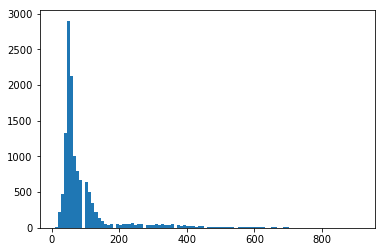

In [85]:
#trying to see distribution of Y
plt.hist(Y, 100)
plt.show()


# Attempt to do feature Engineering

In [106]:
X_egn = X
X_egn[:,-3] = 1/X[:,-3]
#humidity and temp are inversely related
X_egn[:,range(1,17,2)] = 1/X_egn[:,range(1,17,2)]

X_egn1 = X
X_egn1[:,range(1,17,2)] = X_egn1[:,range(1,17,2)]**2

X_egn2 = 1/X_egn

# Costs and other utility functions

In [55]:
def get_cost(W,X,Y):
    n = len(X[0,:])
    m = len(Y)
    cost = 0
    for i in range(0,m):
        cost += (sum(W*X[i,:]) - Y[i])**2
    cost = np.sqrt(cost/(2*m))
    
    return cost

In [9]:
#some variables which may be standard, and helpful for testing
stdX = np.std(X, axis=0)
maxX = np.max(X, axis=0)
minX = np.min(X, axis=0)
meanX = np.mean(X, axis=0)



In [94]:
abc = np.array([-1,-1,-1,1,1,-1])
abc = [2*k for k in abc if k>0 else k]
abc

SyntaxError: invalid syntax (<ipython-input-94-bb175f0d23df>, line 2)

In [102]:
def subgrad(X,Y,lam,p,alpha):
    stdX = np.std(X, axis=0)
    maxX = np.max(X, axis=0)
    minX = np.min(X, axis=0)
    meanX = np.mean(X, axis=0)
    
    ###not needed, not much helpful to scale target values###
    stdY = np.std(Y)
    maxY = np.max(Y)
    minY = np.min(Y)
    meanY = np.mean(Y)
    ##################
    
    #The transformed variables used for reg (standardised)
    
    #min max
    ##X_ = (X - minX)/(maxX-minX)
    ##Y_ = (Y - minY)/(maxY-minY)
    
    ##zscore standardisation
    X_ = (X - meanX)/stdX
    #attempt to avoid outliers
    Y[Y>250] = 250
    
    #iterable range
    n_features = len(maxX) #number of features
    n_samples = len(Y) #number of samples
    
    #initialisation of weights to perform grad descent
    W = 0.01*np.ones(n_features+1)
    W_ = np.zeros(n_features+1)
    
    #vars for descent
    eps = 0.0001
    costs = []
    steps = 0
    #norm_diff_w = np.linalg.norm(W-W_)
    norm_grad = 100
    print('size of X_[0,:]={0} and size of W={1}'.format(len(X_[0,:]), len(W)))
    
    #the optimization
    #appending ones in X_ will help simplify calc
    X_1 = np.append(X_, np.ones([len(X_[:,0]),1]), axis=1)
    while(norm_grad > eps):
        steps += 1
        grad = np.zeros(n_features+1)
        
        
        #cooler way to do things
        hypo = np.dot(X_1,W)
        loss = hypo - Y
        cost = get_cost(W, X_1,Y)
        grad = np.dot(X_1.transpose(),loss)/n_samples
        #to make it general
        for i in range(0,n_features):
            if(abs(W[i]) >0):
                grad[i] += lam*p*(W[i]**p)/(2*abs(W[i]))
        
        W_ = W - alpha*grad
        
        temp = W
        W = W_
        W_ = temp
        
        
        costs.append(get_cost(W,X_1,Y))
        prev_norm_grad = norm_grad
        norm_grad = np.linalg.norm(grad)
        #norm_grad = np.linalg.norm(grad)
        
        '''The following to modify step
        if steps>1:
            prev_cost = costs[-2]
            if prev_cost >= costs[-1]:
                alpha += alpha*0.05
            else:
                #overshoot
                print('overshoot!! correcting')
                temp = W
                W = W_
                W_ = temp
                norm_grad = prev_norm_grad
                alpha -= alpha*0.5
            #norm_diff_w = np.linalg.norm(W-W_)
        '''
        
        '''
        for k in range(n_features+1):
            #print(k)
            dJ_dwk = 0
            for i in range(n_samples):
                #lets not use Y_ but Y
                dJ_dwk += (sum(W*X_1[i,:])-Y[i])*X_1[i,k]
            
            if(abs(W[k])>0 and not(k==n_features)):
                dJ_dwk = dJ_dwk/n_samples + ((lam*p*(W[k]**p))/(2*abs(W[k])))
            #elif(abs(W[k])==0):
            #    dJ_dwk = dJ_dwk/m + 0.00001 #a small constant
            else:
                dJ_dwk = dJ_dwk/n_samples
            
            grad[k] = dJ_dwk
        
        print("new_grad={0} | grad={1}".format(np.linalg.norm(new_grad), np.linalg.norm(grad)))
        W_ = W - alpha*grad
        '''
        print('step={0}, cost={1}, norm_grad={2}'.format(steps, costs[-1], norm_grad))
    #now the loop finshes
    return(W, costs, steps, meanX, stdX)

In [62]:
np.dot([[3,4],[5,6]],[1,2])

array([11, 17])

# simple linear regression

## result without removing anamolies

In [82]:
regRes = subgrad(X, Y, 0, 1, 0.01)

size of X_[0,:]=24 and size of W=25
step=1, cost=73.35804855750501, norm_grad=86.05794153560605
step=2, cost=72.86434848704954, norm_grad=85.18170188105937
step=3, cost=72.37737687728793, norm_grad=84.31495057280256
step=4, cost=71.89705860473201, norm_grad=83.45755313056867
step=5, cost=71.42331949704273, norm_grad=82.6093788389971
step=6, cost=70.95608629589856, norm_grad=81.77030055483695
step=7, cost=70.49528662209335, norm_grad=80.94019452616668
step=8, cost=70.04084894272943, norm_grad=80.1189402228553
step=9, cost=69.59270254038266, norm_grad=79.30642017754121
step=10, cost=69.1507774841182, norm_grad=78.50251983645113
step=11, cost=68.71500460224941, norm_grad=77.70712741942279
step=12, cost=68.28531545673584, norm_grad=76.9201337885398
step=13, cost=67.86164231912409, norm_grad=76.14143232482115
step=14, cost=67.44391814794442, norm_grad=75.37091881244608
step=15, cost=67.03207656747188, norm_grad=74.60849133002749
step=16, cost=66.62605184778387, norm_grad=73.85405014847991
s

step=135, cost=44.953094024664345, norm_grad=22.26314647370759
step=136, cost=44.89929723209459, norm_grad=22.040908602541833
step=137, cost=44.84650641080792, norm_grad=21.82090218079484
step=138, cost=44.79470376703752, norm_grad=21.603104718302284
step=139, cost=44.74387178516613, norm_grad=21.387493954542435
step=140, cost=44.69399322461706, norm_grad=21.17404785621521
step=141, cost=44.64505111673952, norm_grad=20.96274461484901
step=142, cost=44.59702876168754, norm_grad=20.753562644435117
step=143, cost=44.54990972529793, norm_grad=20.5464805790889
step=144, cost=44.50367783596466, norm_grad=20.3414772707381
step=145, cost=44.45831718151417, norm_grad=20.138531786837152
step=146, cost=44.41381210608149, norm_grad=19.93762340810738
step=147, cost=44.37014720698933, norm_grad=19.7387316263031
step=148, cost=44.32730733162975, norm_grad=19.54183614200248
step=149, cost=44.285277574352655, norm_grad=19.346916862423615
step=150, cost=44.24404327335943, norm_grad=19.153953899264966
st

step=267, cost=42.35827382713765, norm_grad=5.966857970933847
step=268, cost=42.354173475003385, norm_grad=5.908186905690104
step=269, cost=42.35015295415778, norm_grad=5.850106078162542
step=270, cost=42.346210699393126, norm_grad=5.792609593525718
step=271, cost=42.3423451760311, norm_grad=5.735691616078971
step=272, cost=42.338554879335014, norm_grad=5.679346368650284
step=273, cost=42.334838333936524, norm_grad=5.6235681320061355
step=274, cost=42.3311940932701, norm_grad=5.5683512442674115
step=275, cost=42.32762073902083, norm_grad=5.513690100331196
step=276, cost=42.324116880579425, norm_grad=5.459579151298438
step=277, cost=42.32068115451086, norm_grad=5.406012903907416
step=278, cost=42.31731222402919, norm_grad=5.352985919972954
step=279, cost=42.31400877848514, norm_grad=5.3004928158312605
step=280, cost=42.310769532861805, norm_grad=5.248528261790474
step=281, cost=42.30759322727956, norm_grad=5.197086981586733
step=282, cost=42.30447862651201, norm_grad=5.1461637518457035


step=399, cost=42.16191891177258, norm_grad=1.6801523836518786
step=400, cost=42.16159168119111, norm_grad=1.664900247398336
step=401, cost=42.16127035311972, norm_grad=1.6498053246008189
step=402, cost=42.16095481386494, norm_grad=1.6348660434804865
step=403, cost=42.160644951968806, norm_grad=1.620080847687834
step=404, cost=42.16034065816419, norm_grad=1.6054481961444307
step=405, cost=42.16004182533287, norm_grad=1.590966562886256
step=406, cost=42.15974834846142, norm_grad=1.5766344369085963
step=407, cost=42.15946012460079, norm_grad=1.5624503220125396
step=408, cost=42.15917705282465, norm_grad=1.5484127366529443
step=409, cost=42.1588990341902, norm_grad=1.5345202137879974
step=410, cost=42.15862597169799, norm_grad=1.5207713007302748
step=411, cost=42.158357770254504, norm_grad=1.5071645589992815
step=412, cost=42.15809433663391, norm_grad=1.4936985641755223
step=413, cost=42.157835579441034, norm_grad=1.480371905756003
step=414, cost=42.1575814090755, norm_grad=1.467183187011

step=531, cost=42.14467996703525, norm_grad=0.5836933164249536
step=532, cost=42.14464020236708, norm_grad=0.5798856100421189
step=533, cost=42.14460095228771, norm_grad=0.5761173667528734
step=534, cost=42.1445622081715, norm_grad=0.5723881437991759
step=535, cost=42.144523961553595, norm_grad=0.5686975027284457
step=536, cost=42.144486204128356, norm_grad=0.5650450093591296
step=537, cost=42.14444892774566, norm_grad=0.5614302337466862
step=538, cost=42.14441212440831, norm_grad=0.5578527501498998
step=539, cost=42.144375786268306, norm_grad=0.5543121369975819
step=540, cost=42.144339905624676, norm_grad=0.550807976855641
step=541, cost=42.14430447492002, norm_grad=0.5473398563944395
step=542, cost=42.144269486738644, norm_grad=0.543907366356571
step=543, cost=42.14423493380188, norm_grad=0.540510101524905
step=544, cost=42.144200808968314, norm_grad=0.5371476606909752
step=545, cost=42.14416710522825, norm_grad=0.5338196466237133
step=546, cost=42.14413381570265, norm_grad=0.5305256

step=662, cost=42.14193602408613, norm_grad=0.30063224179656006
step=663, cost=42.14192540405502, norm_grad=0.2994705116821057
step=664, cost=42.14191486561412, norm_grad=0.2983169700556564
step=665, cost=42.14190440788099, norm_grad=0.2971715200790454
step=666, cost=42.14189402998552, norm_grad=0.2960340662127429
step=667, cost=42.141883731071246, norm_grad=0.29490451420027797
step=668, cost=42.14187351029404, norm_grad=0.29378277105277395
step=669, cost=42.14186336682284, norm_grad=0.29266874503360213
step=670, cost=42.141853299838466, norm_grad=0.2915623456431784
step=671, cost=42.14184330853388, norm_grad=0.29046348360387003
step=672, cost=42.14183339211421, norm_grad=0.289372070845046
step=673, cost=42.141823549796044, norm_grad=0.2882880204882328
step=674, cost=42.14181378080744, norm_grad=0.287211246832419
step=675, cost=42.141804084387886, norm_grad=0.2861416653394897
step=676, cost=42.141794459787626, norm_grad=0.28507919261974807
step=677, cost=42.141784906267965, norm_grad=0

step=791, cost=42.14103063156421, norm_grad=0.19524478632114983
step=792, cost=42.14102614259552, norm_grad=0.19465618060254186
step=793, cost=42.141021680620476, norm_grad=0.19406988505709713
step=794, cost=42.14101724545293, norm_grad=0.19348588302496733
step=795, cost=42.1410128369081, norm_grad=0.19290415805558
step=796, cost=42.141008454802694, norm_grad=0.19232469390447604
step=797, cost=42.141004098955605, norm_grad=0.19174747453020952
step=798, cost=42.140999769187076, norm_grad=0.19117248409128057
step=799, cost=42.1409954653188, norm_grad=0.19059970694312375
step=800, cost=42.140991187174215, norm_grad=0.19002912763513033
step=801, cost=42.140986934578464, norm_grad=0.18946073090773394
step=802, cost=42.14098270735789, norm_grad=0.18889450168952313
step=803, cost=42.140978505340996, norm_grad=0.1883304250944049
step=804, cost=42.140974328357146, norm_grad=0.18776848641880978
step=805, cost=42.14097017623723, norm_grad=0.18720867113894496
step=806, cost=42.14096604881437, norm

step=920, cost=42.140623468925256, norm_grad=0.13421495795497038
step=921, cost=42.1406213466817, norm_grad=0.1338352230238402
step=922, cost=42.1406192364263, norm_grad=0.13345665337547769
step=923, cost=42.14061713808896, norm_grad=0.1330792444219006
step=924, cost=42.14061505159904, norm_grad=0.13270299160779855
step=925, cost=42.140612976887155, norm_grad=0.1323278904101228
step=926, cost=42.14061091388407, norm_grad=0.13195393633767752
step=927, cost=42.14060886252095, norm_grad=0.1315811249307207
step=928, cost=42.14060682272943, norm_grad=0.13120945176057366
step=929, cost=42.14060479444193, norm_grad=0.13083891242922832
step=930, cost=42.140602777590864, norm_grad=0.13046950256896542
step=931, cost=42.1406007721091, norm_grad=0.13010121784198658
step=932, cost=42.140598777930194, norm_grad=0.1297340539400362
step=933, cost=42.14059679498784, norm_grad=0.12936800658404188
step=934, cost=42.14059482321651, norm_grad=0.12900307152375226
step=935, cost=42.14059286255085, norm_grad=

step=1048, cost=42.14042924790626, norm_grad=0.09378051467837274
step=1049, cost=42.14042821160953, norm_grad=0.09352066244487
step=1050, cost=42.14042718104676, norm_grad=0.0932615611370896
step=1051, cost=42.14042615618564, norm_grad=0.09300320841287871
step=1052, cost=42.140425136993834, norm_grad=0.09274560193931676
step=1053, cost=42.14042412343952, norm_grad=0.09248873939264178
step=1054, cost=42.14042311549076, norm_grad=0.09223261845819256
step=1055, cost=42.14042211311559, norm_grad=0.09197723683034374
step=1056, cost=42.140421116283015, norm_grad=0.0917225922124441
step=1057, cost=42.1404201249615, norm_grad=0.09146868231675474
step=1058, cost=42.14041913912021, norm_grad=0.09121550486438981
step=1059, cost=42.14041815872793, norm_grad=0.0909630575852578
step=1060, cost=42.140417183753755, norm_grad=0.09071133821799628
step=1061, cost=42.14041621416746, norm_grad=0.09046034450992518
step=1062, cost=42.14041524993858, norm_grad=0.09021007421697486
step=1063, cost=42.1404142910

step=1176, cost=42.14033388951624, norm_grad=0.06590820851764119
step=1177, cost=42.14033337762247, norm_grad=0.06572806065803224
step=1178, cost=42.14033286852301, norm_grad=0.06554842305112223
step=1179, cost=42.14033236220203, norm_grad=0.06536929419286422
step=1180, cost=42.14033185864428, norm_grad=0.06519067258396755
step=1181, cost=42.140331357834576, norm_grad=0.06501255672987337
step=1182, cost=42.14033085975717, norm_grad=0.06483494514074814
step=1183, cost=42.14033036439719, norm_grad=0.06465783633145313
step=1184, cost=42.14032987173959, norm_grad=0.06448122882153358
step=1185, cost=42.14032938176923, norm_grad=0.0643051211351965
step=1186, cost=42.14032889447147, norm_grad=0.06412951180129678
step=1187, cost=42.14032840983092, norm_grad=0.06395439935331541
step=1188, cost=42.140327927833354, norm_grad=0.06377978232934335
step=1189, cost=42.14032744846389, norm_grad=0.06360565927206162
step=1190, cost=42.14032697170776, norm_grad=0.06343202872872855
step=1191, cost=42.14032

step=1302, cost=42.140287110031615, norm_grad=0.04678180654612993
step=1303, cost=42.1402868521078, norm_grad=0.04665549209993486
step=1304, cost=42.14028659557483, norm_grad=0.046529530749781646
step=1305, cost=42.14028634042503, norm_grad=0.04640392147389494
step=1306, cost=42.14028608665072, norm_grad=0.04627866325356384
step=1307, cost=42.140285834244416, norm_grad=0.04615375507313615
step=1308, cost=42.14028558319864, norm_grad=0.04602919592000749
step=1309, cost=42.140285333505936, norm_grad=0.04590498478460707
step=1310, cost=42.14028508515887, norm_grad=0.045781120660396454
step=1311, cost=42.14028483814982, norm_grad=0.04565760254385285
step=1312, cost=42.14028459247196, norm_grad=0.04553442943446005
step=1313, cost=42.14028434811772, norm_grad=0.04541160033470235
step=1314, cost=42.14028410507962, norm_grad=0.045289114250054614
step=1315, cost=42.140283863350916, norm_grad=0.04516697018896623
step=1316, cost=42.14028362292388, norm_grad=0.04504516716286478
step=1317, cost=42.

step=1429, cost=42.140263322608796, norm_grad=0.03325373502520868
step=1430, cost=42.14026319227619, norm_grad=0.03316501812473627
step=1431, cost=42.14026306263792, norm_grad=0.03307654616390807
step=1432, cost=42.14026293369007, norm_grad=0.03298831844266602
step=1433, cost=42.14026280542939, norm_grad=0.032900334263010964
step=1434, cost=42.14026267785162, norm_grad=0.03281259292900953
step=1435, cost=42.14026255095364, norm_grad=0.0327250937467758
step=1436, cost=42.14026242473142, norm_grad=0.03263783602447839
step=1437, cost=42.14026229918103, norm_grad=0.032550819072316856
step=1438, cost=42.140262174299465, norm_grad=0.03246404220253254
step=1439, cost=42.14026205008273, norm_grad=0.03237750472939158
step=1440, cost=42.14026192652702, norm_grad=0.03229120596918496
step=1441, cost=42.14026180362943, norm_grad=0.032205145240216684
step=1442, cost=42.14026168138559, norm_grad=0.03211932186280245
step=1443, cost=42.14026155979237, norm_grad=0.03203373515926065
step=1444, cost=42.14

step=1555, cost=42.14025132628582, norm_grad=0.02379566859199494
step=1556, cost=42.1402512595432, norm_grad=0.02373291512353648
step=1557, cost=42.140251193152444, norm_grad=0.02367033279245153
step=1558, cost=42.140251127111114, norm_grad=0.023607921115324
step=1559, cost=42.14025106141773, norm_grad=0.023545679610153795
step=1560, cost=42.14025099607004, norm_grad=0.02348360779634303
step=1561, cost=42.1402509310664, norm_grad=0.023421705194698085
step=1562, cost=42.14025086640508, norm_grad=0.023359971327425965
step=1563, cost=42.14025080208407, norm_grad=0.02329840571812264
step=1564, cost=42.140250738101784, norm_grad=0.0232370078917804
step=1565, cost=42.140250674456084, norm_grad=0.023175777374772475
step=1566, cost=42.14025061114509, norm_grad=0.02311471369485423
step=1567, cost=42.140250548167614, norm_grad=0.02305381638116122
step=1568, cost=42.14025048552141, norm_grad=0.02299308496420171
step=1569, cost=42.140250423204876, norm_grad=0.022932518975850146
step=1570, cost=42.

step=1680, cost=42.14024519694996, norm_grad=0.017136934481413655
step=1681, cost=42.14024516233162, norm_grad=0.017092236912548065
step=1682, cost=42.14024512789377, norm_grad=0.01704765976139261
step=1683, cost=42.14024509363546, norm_grad=0.017003202691865515
step=1684, cost=42.14024505955546, norm_grad=0.016958865368852282
step=1685, cost=42.140245025652916, norm_grad=0.016914647458206766
step=1686, cost=42.14024499192687, norm_grad=0.016870548626749967
step=1687, cost=42.140244958376485, norm_grad=0.016826568542262305
step=1688, cost=42.14024492500073, norm_grad=0.01678270687348466
step=1689, cost=42.140244891798815, norm_grad=0.01673896329011319
step=1690, cost=42.14024485876966, norm_grad=0.016695337462800178
step=1691, cost=42.14024482591237, norm_grad=0.016651829063145444
step=1692, cost=42.14024479322617, norm_grad=0.01660843776369868
step=1693, cost=42.14024476071012, norm_grad=0.016565163237956416
step=1694, cost=42.14024472836327, norm_grad=0.01652200516035286
step=1695, c

step=1805, cost=42.140242007763895, norm_grad=0.012384954874133611
step=1806, cost=42.14024198968159, norm_grad=0.012352987283754308
step=1807, cost=42.14024197169242, norm_grad=0.012321104785665239
step=1808, cost=42.140241953795865, norm_grad=0.012289307145299725
step=1809, cost=42.140241935991746, norm_grad=0.012257594128757088
step=1810, cost=42.14024191827918, norm_grad=0.01222596550280749
step=1811, cost=42.14024190065809, norm_grad=0.01219442103488618
step=1812, cost=42.14024188312768, norm_grad=0.012162960493090994
step=1813, cost=42.14024186568782, norm_grad=0.01213158364618475
step=1814, cost=42.14024184833747, norm_grad=0.012100290263587842
step=1815, cost=42.140241831076736, norm_grad=0.012069080115380293
step=1816, cost=42.14024181390488, norm_grad=0.01203795297229815
step=1817, cost=42.140241796821336, norm_grad=0.012006908605733568
step=1818, cost=42.14024177982588, norm_grad=0.011975946787728137
step=1819, cost=42.14024176291795, norm_grad=0.011945067290976556
step=1820

step=1930, cost=42.14024033703373, norm_grad=0.008979993904789806
step=1931, cost=42.1402403275265, norm_grad=0.008957040018616729
step=1932, cost=42.14024031806788, norm_grad=0.008934146522493592
step=1933, cost=42.14024030865773, norm_grad=0.008911313252023394
step=1934, cost=42.14024029929544, norm_grad=0.008888540043278699
step=1935, cost=42.14024028998107, norm_grad=0.00886582673279393
step=1936, cost=42.14024028071425, norm_grad=0.00884317315756364
step=1937, cost=42.140240271494584, norm_grad=0.008820579155043086
step=1938, cost=42.140240262322095, norm_grad=0.008798044563146042
step=1939, cost=42.14024025319639, norm_grad=0.008775569220242144
step=1940, cost=42.14024024411707, norm_grad=0.008753152965160792
step=1941, cost=42.140240235084235, norm_grad=0.008730795637181807
step=1942, cost=42.14024022609749, norm_grad=0.008708497076041233
step=1943, cost=42.14024021715653, norm_grad=0.008686257121924851
step=1944, cost=42.14024020826124, norm_grad=0.00866407561547025
step=1945, 

step=2054, cost=42.14023946129941, norm_grad=0.006547329739476318
step=2055, cost=42.14023945624517, norm_grad=0.0065307426181489365
step=2056, cost=42.140239451216516, norm_grad=0.0065141986561645686
step=2057, cost=42.14023944621353, norm_grad=0.006497697737486389
step=2058, cost=42.14023944123556, norm_grad=0.006481239746405515
step=2059, cost=42.140239436282826, norm_grad=0.006464824567534371
step=2060, cost=42.14023943135529, norm_grad=0.0064484520858081726
step=2061, cost=42.1402394264528, norm_grad=0.006432122186478306
step=2062, cost=42.140239421574826, norm_grad=0.0064158347551244044
step=2063, cost=42.1402394167217, norm_grad=0.006399589677636976
step=2064, cost=42.14023941189314, norm_grad=0.006383386840227974
step=2065, cost=42.140239407088956, norm_grad=0.006367226129425069
step=2066, cost=42.140239402308886, norm_grad=0.006351107432073453
step=2067, cost=42.14023939755306, norm_grad=0.006335030635333935
step=2068, cost=42.140239392821336, norm_grad=0.0063189956266792875
s

step=2179, cost=42.14023899190878, norm_grad=0.004774483136505092
step=2180, cost=42.140238989221, norm_grad=0.0047624860206057105
step=2181, cost=42.14023898654681, norm_grad=0.004750519795059064
step=2182, cost=42.14023898388584, norm_grad=0.0047385843778332375
step=2183, cost=42.14023898123828, norm_grad=0.0047266796871225
step=2184, cost=42.14023897860413, norm_grad=0.004714805641344005
step=2185, cost=42.14023897598311, norm_grad=0.0047029621591424126
step=2186, cost=42.140238973375254, norm_grad=0.004691149159384577
step=2187, cost=42.140238970780366, norm_grad=0.004679366561157827
step=2188, cost=42.140238968198645, norm_grad=0.004667614283778468
step=2189, cost=42.14023896562988, norm_grad=0.004655892246780588
step=2190, cost=42.14023896307386, norm_grad=0.004644200369919617
step=2191, cost=42.14023896053085, norm_grad=0.004632538573170505
step=2192, cost=42.14023895800059, norm_grad=0.004620906776732073
step=2193, cost=42.14023895548286, norm_grad=0.004609304901019853
step=219

step=2303, cost=42.14023874317664, norm_grad=0.003498951380406434
step=2304, cost=42.140238741733185, norm_grad=0.003490223463481913
step=2305, cost=42.14023874029684, norm_grad=0.0034815178033370327
step=2306, cost=42.14023873886754, norm_grad=0.0034728343415558224
step=2307, cost=42.14023873744543, norm_grad=0.0034641730198852246
step=2308, cost=42.14023873603049, norm_grad=0.0034555337802287664
step=2309, cost=42.140238734622514, norm_grad=0.003446916564647182
step=2310, cost=42.14023873322147, norm_grad=0.003438321315359252
step=2311, cost=42.1402387318275, norm_grad=0.0034297479747416454
step=2312, cost=42.140238730440615, norm_grad=0.0034211964853260793
step=2313, cost=42.1402387290604, norm_grad=0.0034126667898013072
step=2314, cost=42.1402387276872, norm_grad=0.003404158831009373
step=2315, cost=42.14023872632066, norm_grad=0.0033956725519485283
step=2316, cost=42.14023872496105, norm_grad=0.0033872078957784195
step=2317, cost=42.14023872360831, norm_grad=0.003378764805800607
s

step=2427, cost=42.14023860932573, norm_grad=0.002569698104487745
step=2428, cost=42.14023860854698, norm_grad=0.0025633298641879834
step=2429, cost=42.14023860777212, norm_grad=0.002556977720300577
step=2430, cost=42.1402386070013, norm_grad=0.0025506416310519973
step=2431, cost=42.14023860623412, norm_grad=0.002544321554775073
step=2432, cost=42.140238605470685, norm_grad=0.0025380174499200787
step=2433, cost=42.14023860471127, norm_grad=0.0025317292750438774
step=2434, cost=42.14023860395523, norm_grad=0.002525456988816076
step=2435, cost=42.14023860320321, norm_grad=0.0025192005500194186
step=2436, cost=42.14023860245482, norm_grad=0.002512959917542108
step=2437, cost=42.14023860171036, norm_grad=0.002506735050389146
step=2438, cost=42.14023860096925, norm_grad=0.0025005259076689595
step=2439, cost=42.140238600232045, norm_grad=0.0024943324486049463
step=2440, cost=42.140238599498346, norm_grad=0.0024881546325264837
step=2441, cost=42.14023859876836, norm_grad=0.0024819924188719707

step=2551, cost=42.14023853700249, norm_grad=0.0018908165286620924
step=2552, cost=42.14023853658091, norm_grad=0.0018861576735049823
step=2553, cost=42.14023853616141, norm_grad=0.0018815105001755224
step=2554, cost=42.14023853574402, norm_grad=0.0018768749786700542
step=2555, cost=42.14023853532857, norm_grad=0.0018722510790632968
step=2556, cost=42.14023853491538, norm_grad=0.0018676387715100367
step=2557, cost=42.14023853450393, norm_grad=0.001863038026241856
step=2558, cost=42.14023853409457, norm_grad=0.0018584488135731767
step=2559, cost=42.14023853368728, norm_grad=0.0018538711038939282
step=2560, cost=42.1402385332819, norm_grad=0.0018493048676744641
step=2561, cost=42.14023853287862, norm_grad=0.0018447500754594159
step=2562, cost=42.140238532477404, norm_grad=0.0018402066978786492
step=2563, cost=42.14023853207814, norm_grad=0.0018356747056322584
step=2564, cost=42.14023853168064, norm_grad=0.0018311540694999802
step=2565, cost=42.14023853128529, norm_grad=0.0018266447603453

step=2675, cost=42.140238497784544, norm_grad=0.0013935981967646493
step=2676, cost=42.14023849755563, norm_grad=0.0013901818092853717
step=2677, cost=42.14023849732764, norm_grad=0.0013867739269817201
step=2678, cost=42.14023849710085, norm_grad=0.0013833745282170642
step=2679, cost=42.140238496875334, norm_grad=0.0013799835914118104
step=2680, cost=42.14023849665056, norm_grad=0.0013766010950410966
step=2681, cost=42.140238496427195, norm_grad=0.001373227017640632
step=2682, cost=42.140238496204795, norm_grad=0.001369861337799421
step=2683, cost=42.14023849598359, norm_grad=0.001366504034159423
step=2684, cost=42.140238495763356, norm_grad=0.0013631550854268488
step=2685, cost=42.1402384955442, norm_grad=0.0013598144703540964
step=2686, cost=42.14023849532614, norm_grad=0.0013564821677573
step=2687, cost=42.140238495109166, norm_grad=0.0013531581565008343
step=2688, cost=42.14023849489309, norm_grad=0.001349842415512326
step=2689, cost=42.140238494678286, norm_grad=0.0013465349237659

step=2798, cost=42.14023847657721, norm_grad=0.001031132026216198
step=2799, cost=42.1402384764518, norm_grad=0.0010286152720316978
step=2800, cost=42.14023847632699, norm_grad=0.0010261047439112485
step=2801, cost=42.1402384762029, norm_grad=0.0010236004261524403
step=2802, cost=42.1402384760794, norm_grad=0.001021102303093541
step=2803, cost=42.1402384759563, norm_grad=0.0010186103591139862
step=2804, cost=42.14023847583399, norm_grad=0.0010161245786367561
step=2805, cost=42.14023847571219, norm_grad=0.0010136449461179003
step=2806, cost=42.14023847559116, norm_grad=0.0010111714460596956
step=2807, cost=42.14023847547066, norm_grad=0.001008704063002908
step=2808, cost=42.14023847535056, norm_grad=0.001006242781528069
step=2809, cost=42.14023847523111, norm_grad=0.0010037875862541246
step=2810, cost=42.14023847511224, norm_grad=0.0010013384618424038
step=2811, cost=42.14023847499405, norm_grad=0.0009988953929942316
step=2812, cost=42.14023847487641, norm_grad=0.0009964583644461536
ste

step=2922, cost=42.140238464884746, norm_grad=0.0007620231119878269
step=2923, cost=42.140238464816356, norm_grad=0.0007601702981871404
step=2924, cost=42.14023846474813, norm_grad=0.0007583220423378603
step=2925, cost=42.14023846468029, norm_grad=0.000756478333032432
step=2926, cost=42.14023846461277, norm_grad=0.0007546391588960238
step=2927, cost=42.140238464545604, norm_grad=0.0007528045085823522
step=2928, cost=42.14023846447885, norm_grad=0.0007509743707746936
step=2929, cost=42.140238464412256, norm_grad=0.0007491487341840681
step=2930, cost=42.14023846434609, norm_grad=0.0007473275875507396
step=2931, cost=42.140238464280266, norm_grad=0.0007455109196450444
step=2932, cost=42.14023846421475, norm_grad=0.0007436987192644373
step=2933, cost=42.14023846414952, norm_grad=0.0007418909752363392
step=2934, cost=42.14023846408451, norm_grad=0.0007400876764154952
step=2935, cost=42.140238464020015, norm_grad=0.0007382888116870365
step=2936, cost=42.14023846395572, norm_grad=0.0007364943

step=3046, cost=42.14023845849235, norm_grad=0.0005637538644521482
step=3047, cost=42.140238458455094, norm_grad=0.00056238764600451
step=3048, cost=42.14023845841781, norm_grad=0.0005610247720533078
step=3049, cost=42.14023845838071, norm_grad=0.0005596652342903674
step=3050, cost=42.140238458343745, norm_grad=0.0005583090244246867
step=3051, cost=42.14023845830694, norm_grad=0.0005569561341867355
step=3052, cost=42.140238458270346, norm_grad=0.00055560655533333
step=3053, cost=42.14023845823404, norm_grad=0.0005542602796362905
step=3054, cost=42.14023845819773, norm_grad=0.000552917298889557
step=3055, cost=42.140238458161605, norm_grad=0.0005515776049116825
step=3056, cost=42.1402384581258, norm_grad=0.0005502411895362365
step=3057, cost=42.140238458090074, norm_grad=0.0005489080446238235
step=3058, cost=42.14023845805471, norm_grad=0.0005475781620483192
step=3059, cost=42.14023845801927, norm_grad=0.000546251533711403
step=3060, cost=42.14023845798403, norm_grad=0.00054492815152870

step=3169, cost=42.1402384550117, norm_grad=0.00041846812303749834
step=3170, cost=42.14023845499111, norm_grad=0.00041745683987756867
step=3171, cost=42.14023845497046, norm_grad=0.0004164480219109248
step=3172, cost=42.14023845495, norm_grad=0.0004154416630478907
step=3173, cost=42.14023845492952, norm_grad=0.0004144377572201393
step=3174, cost=42.14023845490933, norm_grad=0.0004134362983648094
step=3175, cost=42.14023845488908, norm_grad=0.00041243728044559067
step=3176, cost=42.14023845486908, norm_grad=0.0004114406974325973
step=3177, cost=42.140238454849154, norm_grad=0.0004104465433152284
step=3178, cost=42.14023845482931, norm_grad=0.00040945481209766257
step=3179, cost=42.14023845480949, norm_grad=0.000408465497795993
step=3180, cost=42.14023845478982, norm_grad=0.000407478594447195
step=3181, cost=42.14023845477023, norm_grad=0.00040649409609802887
step=3182, cost=42.140238454750786, norm_grad=0.0004055119968121392
step=3183, cost=42.14023845473132, norm_grad=0.00040453229066

step=3291, cost=42.14023845310364, norm_grad=0.0003116165696293258
step=3292, cost=42.14023845309215, norm_grad=0.0003108653020711203
step=3293, cost=42.140238453080826, norm_grad=0.0003101158592520127
step=3294, cost=42.14023845306944, norm_grad=0.0003093682366925301
step=3295, cost=42.14023845305815, norm_grad=0.00030862242991828856
step=3296, cost=42.14023845304693, norm_grad=0.00030787843447031485
step=3297, cost=42.140238453035856, norm_grad=0.0003071362459024868
step=3298, cost=42.14023845302457, norm_grad=0.0003063958597759524
step=3299, cost=42.14023845301355, norm_grad=0.00030565727166264787
step=3300, cost=42.14023845300257, norm_grad=0.0003049204771465449
step=3301, cost=42.14023845299157, norm_grad=0.00030418547182734114
step=3302, cost=42.140238452980626, norm_grad=0.00030345225130789334
step=3303, cost=42.14023845296983, norm_grad=0.00030272081120732275
step=3304, cost=42.140238452959125, norm_grad=0.0003019911471561968
step=3305, cost=42.14023845294818, norm_grad=0.00030

step=3413, cost=42.14023845204495, norm_grad=0.00023219969242107912
step=3414, cost=42.14023845203861, norm_grad=0.0002316410284224965
step=3415, cost=42.14023845203236, norm_grad=0.00023108371713018868
step=3416, cost=42.140238452026, norm_grad=0.00023052775523367934
step=3417, cost=42.14023845201991, norm_grad=0.0002299731394382405
step=3418, cost=42.14023845201356, norm_grad=0.0002294198664521554
step=3419, cost=42.140238452007345, norm_grad=0.00022886793299020243
step=3420, cost=42.14023845200119, norm_grad=0.0002283173357789315
step=3421, cost=42.14023845199498, norm_grad=0.00022776807155376486
step=3422, cost=42.140238451989, norm_grad=0.00022722013705429305
step=3423, cost=42.14023845198284, norm_grad=0.00022667352903061553
step=3424, cost=42.14023845197661, norm_grad=0.00022612824424014626
step=3425, cost=42.14023845197062, norm_grad=0.00022558427945229542
step=3426, cost=42.14023845196466, norm_grad=0.0002250416314352756
step=3427, cost=42.14023845195875, norm_grad=0.000224500

step=3535, cost=42.14023845145698, norm_grad=0.00017311852966508812
step=3536, cost=42.14023845145341, norm_grad=0.00017270273511266177
step=3537, cost=42.14023845144986, norm_grad=0.00017228794464376563
step=3538, cost=42.14023845144637, norm_grad=0.00017187415581479068
step=3539, cost=42.140238451442954, norm_grad=0.00017146136618519933
step=3540, cost=42.14023845143943, norm_grad=0.00017104957332092068
step=3541, cost=42.140238451436055, norm_grad=0.00017063877479724592
step=3542, cost=42.14023845143252, norm_grad=0.00017022896819331645
step=3543, cost=42.14023845142907, norm_grad=0.00016982015109297022
step=3544, cost=42.140238451425724, norm_grad=0.0001694123210879259
step=3545, cost=42.14023845142227, norm_grad=0.00016900547577461164
step=3546, cost=42.14023845141897, norm_grad=0.00016859961275517623
step=3547, cost=42.140238451415556, norm_grad=0.000168194729640387
step=3548, cost=42.14023845141233, norm_grad=0.000167790824041094
step=3549, cost=42.14023845140893, norm_grad=0.00

step=3657, cost=42.1402384511299, norm_grad=0.00012913084133494714
step=3658, cost=42.1402384511279, norm_grad=0.00012882115311121838
step=3659, cost=42.14023845112606, norm_grad=0.00012851221103096896
step=3660, cost=42.14023845112388, norm_grad=0.00012820401328524411
step=3661, cost=42.140238451122094, norm_grad=0.00012789655806613655
step=3662, cost=42.14023845112021, norm_grad=0.00012758984357312748
step=3663, cost=42.14023845111829, norm_grad=0.00012728386801042917
step=3664, cost=42.14023845111633, norm_grad=0.00012697862958189178
step=3665, cost=42.14023845111435, norm_grad=0.0001266741265008635
step=3666, cost=42.140238451112566, norm_grad=0.00012637035698328226
step=3667, cost=42.1402384511106, norm_grad=0.00012606731924939
step=3668, cost=42.140238451108765, norm_grad=0.00012576501152263502
step=3669, cost=42.140238451106796, norm_grad=0.00012546343203475782
step=3670, cost=42.14023845110504, norm_grad=0.00012516257901658848
step=3671, cost=42.14023845110312, norm_grad=0.0001

step=3778, cost=42.140238450949, norm_grad=9.658979828306566e-05
step=3779, cost=42.14023845094777, norm_grad=9.635843903187931e-05
step=3780, cost=42.140238450946725, norm_grad=9.612763612540383e-05
step=3781, cost=42.14023845094569, norm_grad=9.589738822071803e-05
step=3782, cost=42.14023845094444, norm_grad=9.566769397334937e-05
step=3783, cost=42.140238450943485, norm_grad=9.543855204297533e-05
step=3784, cost=42.14023845094238, norm_grad=9.520996109542223e-05
step=3785, cost=42.140238450941325, norm_grad=9.4981919796096e-05
step=3786, cost=42.14023845094029, norm_grad=9.475442681430244e-05
step=3787, cost=42.14023845093911, norm_grad=9.452748082763202e-05
step=3788, cost=42.14023845093804, norm_grad=9.430108050959381e-05
step=3789, cost=42.14023845093722, norm_grad=9.407522454188446e-05
step=3790, cost=42.14023845093606, norm_grad=9.384991160523852e-05
step=3791, cost=42.140238450935, norm_grad=9.362514039027076e-05
step=3792, cost=42.14023845093383, norm_grad=9.340090958277585e-0

step=3902, cost=42.14023845084583, norm_grad=7.175560690323862e-05
step=3903, cost=42.14023845084518, norm_grad=7.158391729136302e-05
step=3904, cost=42.1402384508447, norm_grad=7.141263984544768e-05
step=3905, cost=42.140238450844095, norm_grad=7.124177356942445e-05
step=3906, cost=42.140238450843384, norm_grad=7.107131747079726e-05
step=3907, cost=42.14023845084285, norm_grad=7.090127056066674e-05
step=3908, cost=42.14023845084232, norm_grad=7.073163184947825e-05
step=3909, cost=42.14023845084163, norm_grad=7.056240035575099e-05
step=3910, cost=42.14023845084107, norm_grad=7.039357509327801e-05
step=3911, cost=42.14023845084044, norm_grad=7.022515508569496e-05
step=3912, cost=42.14023845083987, norm_grad=7.005713935249087e-05
step=3913, cost=42.140238450839384, norm_grad=6.988952691857651e-05
step=3914, cost=42.14023845083876, norm_grad=6.972231681224872e-05
step=3915, cost=42.14023845083812, norm_grad=6.955550806162717e-05
step=3916, cost=42.14023845083749, norm_grad=6.9389099698235

step=4024, cost=42.14023845078962, norm_grad=5.357809019170845e-05
step=4025, cost=42.14023845078929, norm_grad=5.345000847261763e-05
step=4026, cost=42.140238450788736, norm_grad=5.332223379869663e-05
step=4027, cost=42.140238450788665, norm_grad=5.3194765432053074e-05
step=4028, cost=42.14023845078839, norm_grad=5.3067602636139564e-05
step=4029, cost=42.140238450787876, norm_grad=5.2940744673831264e-05
step=4030, cost=42.14023845078767, norm_grad=5.28141908099546e-05
step=4031, cost=42.14023845078716, norm_grad=5.268794031301213e-05
step=4032, cost=42.1402384507869, norm_grad=5.2561992454173e-05
step=4033, cost=42.14023845078669, norm_grad=5.243634650341876e-05
step=4034, cost=42.14023845078628, norm_grad=5.231100173425652e-05
step=4035, cost=42.14023845078587, norm_grad=5.2185957421412925e-05
step=4036, cost=42.14023845078555, norm_grad=5.206121284099498e-05
step=4037, cost=42.14023845078525, norm_grad=5.1936767273174844e-05
step=4038, cost=42.14023845078488, norm_grad=5.18126199973

step=4146, cost=42.140238450758126, norm_grad=4.001502816766195e-05
step=4147, cost=42.14023845075802, norm_grad=3.991944196653776e-05
step=4148, cost=42.14023845075775, norm_grad=3.9824084635973926e-05
step=4149, cost=42.14023845075769, norm_grad=3.972895563052402e-05
step=4150, cost=42.14023845075737, norm_grad=3.963405439837125e-05
step=4151, cost=42.14023845075736, norm_grad=3.9539380394644896e-05
step=4152, cost=42.14023845075727, norm_grad=3.9444933070187125e-05
step=4153, cost=42.14023845075692, norm_grad=3.935071188303562e-05
step=4154, cost=42.140238450756755, norm_grad=3.9256716287561685e-05
step=4155, cost=42.1402384507566, norm_grad=3.916294574371075e-05
step=4156, cost=42.14023845075627, norm_grad=3.906939970889625e-05
step=4157, cost=42.140238450756236, norm_grad=3.897607764512661e-05
step=4158, cost=42.14023845075618, norm_grad=3.888297901370312e-05
step=4159, cost=42.14023845075577, norm_grad=3.8790103275608165e-05
step=4160, cost=42.14023845075575, norm_grad=3.86974498

step=4269, cost=42.14023845074049, norm_grad=2.9820104294550168e-05
step=4270, cost=42.14023845074041, norm_grad=2.9748916977836457e-05
step=4271, cost=42.1402384507404, norm_grad=2.9677899941671234e-05
step=4272, cost=42.140238450740334, norm_grad=2.96070527773801e-05
step=4273, cost=42.14023845074023, norm_grad=2.953637507310949e-05
step=4274, cost=42.140238450740135, norm_grad=2.9465866425912898e-05
step=4275, cost=42.140238450740014, norm_grad=2.9395526432054946e-05
step=4276, cost=42.14023845073984, norm_grad=2.932535468264625e-05
step=4277, cost=42.140238450739815, norm_grad=2.925535077652661e-05
step=4278, cost=42.14023845073977, norm_grad=2.918551431023034e-05
step=4279, cost=42.140238450739666, norm_grad=2.9115844882048764e-05
step=4280, cost=42.14023845073954, norm_grad=2.9046342090840867e-05
step=4281, cost=42.14023845073934, norm_grad=2.897700553647444e-05
step=4282, cost=42.14023845073943, norm_grad=2.8907834821917036e-05
step=4283, cost=42.14023845073928, norm_grad=2.8838

step=4390, cost=42.14023845073099, norm_grad=2.233291754591063e-05
step=4391, cost=42.140238450730855, norm_grad=2.2279632184296914e-05
step=4392, cost=42.14023845073069, norm_grad=2.2226474170728225e-05
step=4393, cost=42.14023845073081, norm_grad=2.2173443205644608e-05
step=4394, cost=42.14023845073079, norm_grad=2.21205389782268e-05
step=4395, cost=42.1402384507307, norm_grad=2.206776119199388e-05
step=4396, cost=42.14023845073054, norm_grad=2.2015109537322834e-05
step=4397, cost=42.14023845073064, norm_grad=2.196258371628829e-05
step=4398, cost=42.14023845073047, norm_grad=2.1910183425691115e-05
step=4399, cost=42.14023845073053, norm_grad=2.1857908364188407e-05
step=4400, cost=42.14023845073038, norm_grad=2.180575823320526e-05
step=4401, cost=42.14023845073029, norm_grad=2.1753732732019113e-05
step=4402, cost=42.14023845073024, norm_grad=2.1701831563226868e-05
step=4403, cost=42.14023845073035, norm_grad=2.1650054428261514e-05
step=4404, cost=42.14023845073019, norm_grad=2.1598401

step=4512, cost=42.14023845072546, norm_grad=1.6688077196362492e-05
step=4513, cost=42.140238450725356, norm_grad=1.6648278169016776e-05
step=4514, cost=42.14023845072546, norm_grad=1.6608574190391496e-05
step=4515, cost=42.14023845072557, norm_grad=1.656896503562435e-05
step=4516, cost=42.14023845072532, norm_grad=1.6529450478235684e-05
step=4517, cost=42.14023845072528, norm_grad=1.649003028788746e-05
step=4518, cost=42.14023845072534, norm_grad=1.6450704241788363e-05
step=4519, cost=42.1402384507253, norm_grad=1.641147211544637e-05
step=4520, cost=42.14023845072528, norm_grad=1.637233368077714e-05
step=4521, cost=42.1402384507252, norm_grad=1.6333288716939012e-05
step=4522, cost=42.14023845072519, norm_grad=1.6294336998474523e-05
step=4523, cost=42.140238450725064, norm_grad=1.6255478302451075e-05
step=4524, cost=42.14023845072508, norm_grad=1.6216712405528268e-05
step=4525, cost=42.140238450725136, norm_grad=1.617803908679213e-05
step=4526, cost=42.14023845072508, norm_grad=1.61394

step=4634, cost=42.14023845072249, norm_grad=1.2471530873585978e-05
step=4635, cost=42.140238450722435, norm_grad=1.244179910559226e-05
step=4636, cost=42.1402384507224, norm_grad=1.241213830323452e-05
step=4637, cost=42.14023845072238, norm_grad=1.2382548295673647e-05
step=4638, cost=42.14023845072242, norm_grad=1.2353028913209987e-05
step=4639, cost=42.140238450722336, norm_grad=1.2323579986128098e-05
step=4640, cost=42.140238450722414, norm_grad=1.2294201349263049e-05
step=4641, cost=42.14023845072246, norm_grad=1.2264892830225366e-05
step=4642, cost=42.140238450722414, norm_grad=1.2235654264650208e-05
step=4643, cost=42.14023845072247, norm_grad=1.2206485485069221e-05
step=4644, cost=42.14023845072236, norm_grad=1.217738632192024e-05
step=4645, cost=42.140238450722315, norm_grad=1.214835661121637e-05
step=4646, cost=42.14023845072232, norm_grad=1.2119396184414904e-05
step=4647, cost=42.14023845072215, norm_grad=1.2090504879086988e-05
step=4648, cost=42.140238450722165, norm_grad=1.

step=4756, cost=42.14023845072069, norm_grad=9.321321786608194e-06
step=4757, cost=42.14023845072069, norm_grad=9.299107137094284e-06
step=4758, cost=42.1402384507207, norm_grad=9.276945484922904e-06
step=4759, cost=42.14023845072073, norm_grad=9.25483669951311e-06
step=4760, cost=42.140238450720794, norm_grad=9.232780656318835e-06
step=4761, cost=42.14023845072078, norm_grad=9.21077723009176e-06
step=4762, cost=42.14023845072078, norm_grad=9.188826294598464e-06
step=4763, cost=42.14023845072072, norm_grad=9.166927723080332e-06
step=4764, cost=42.140238450720574, norm_grad=9.1450813927935e-06
step=4765, cost=42.14023845072071, norm_grad=9.123287177467406e-06
step=4766, cost=42.14023845072068, norm_grad=9.101544953180791e-06
step=4767, cost=42.140238450720645, norm_grad=9.079854596110946e-06
step=4768, cost=42.14023845072051, norm_grad=9.058215981487832e-06
step=4769, cost=42.140238450720666, norm_grad=9.03662898505705e-06
step=4770, cost=42.140238450720716, norm_grad=9.015093483681394e

step=4880, cost=42.140238450719835, norm_grad=6.934266339345134e-06
step=4881, cost=42.1402384507198, norm_grad=6.9177450524756744e-06
step=4882, cost=42.140238450719856, norm_grad=6.901263162321106e-06
step=4883, cost=42.14023845071982, norm_grad=6.884820574512274e-06
step=4884, cost=42.14023845071977, norm_grad=6.868417195397664e-06
step=4885, cost=42.140238450719835, norm_grad=6.85205293068599e-06
step=4886, cost=42.140238450719735, norm_grad=6.835727686305734e-06
step=4887, cost=42.14023845071979, norm_grad=6.8194413701801785e-06
step=4888, cost=42.14023845071982, norm_grad=6.803193888391076e-06
step=4889, cost=42.14023845071981, norm_grad=6.786985150611894e-06
step=4890, cost=42.14023845071973, norm_grad=6.770815061628229e-06
step=4891, cost=42.140238450719764, norm_grad=6.754683531018029e-06
step=4892, cost=42.1402384507198, norm_grad=6.738590464978641e-06
step=4893, cost=42.14023845071965, norm_grad=6.722535772284292e-06
step=4894, cost=42.1402384507199, norm_grad=6.706519363007

step=5004, cost=42.14023845071939, norm_grad=5.158884042780257e-06
step=5005, cost=42.14023845071936, norm_grad=5.146595520216042e-06
step=5006, cost=42.14023845071937, norm_grad=5.134336290070008e-06
step=5007, cost=42.14023845071921, norm_grad=5.122106282328504e-06
step=5008, cost=42.14023845071941, norm_grad=5.1099054267717164e-06
step=5009, cost=42.14023845071921, norm_grad=5.097733653538509e-06
step=5010, cost=42.14023845071928, norm_grad=5.08559089469297e-06
step=5011, cost=42.14023845071928, norm_grad=5.073477078864144e-06
step=5012, cost=42.14023845071933, norm_grad=5.061392139883299e-06
step=5013, cost=42.14023845071932, norm_grad=5.049336006882102e-06
step=5014, cost=42.14023845071937, norm_grad=5.0373086111683106e-06
step=5015, cost=42.14023845071928, norm_grad=5.025309883782428e-06
step=5016, cost=42.140238450719245, norm_grad=5.013339757462106e-06
step=5017, cost=42.14023845071911, norm_grad=5.001398162164805e-06
step=5018, cost=42.14023845071931, norm_grad=4.9894850335355

step=5127, cost=42.14023845071894, norm_grad=3.847455007239666e-06
step=5128, cost=42.14023845071891, norm_grad=3.838292069398008e-06
step=5129, cost=42.140238450719, norm_grad=3.829150967368734e-06
step=5130, cost=42.14023845071905, norm_grad=3.820031645899377e-06
step=5131, cost=42.14023845071889, norm_grad=3.810934057756094e-06
step=5132, cost=42.14023845071883, norm_grad=3.8018581477659146e-06
step=5133, cost=42.14023845071893, norm_grad=3.7928038665848743e-06
step=5134, cost=42.14023845071899, norm_grad=3.783771159958345e-06
step=5135, cost=42.14023845071903, norm_grad=3.7747599772325375e-06
step=5136, cost=42.14023845071916, norm_grad=3.7657702687766315e-06
step=5137, cost=42.14023845071902, norm_grad=3.7568019813512024e-06
step=5138, cost=42.140238450718954, norm_grad=3.747855064456711e-06
step=5139, cost=42.14023845071888, norm_grad=3.738929468934545e-06
step=5140, cost=42.14023845071882, norm_grad=3.730025138826273e-06
step=5141, cost=42.140238450719, norm_grad=3.7211420298601

step=5249, cost=42.140238450719, norm_grad=2.876398070504305e-06
step=5250, cost=42.140238450718925, norm_grad=2.8695488466861333e-06
step=5251, cost=42.14023845071883, norm_grad=2.862715942044575e-06
step=5252, cost=42.14023845071877, norm_grad=2.8558993141694844e-06
step=5253, cost=42.14023845071874, norm_grad=2.849098927418561e-06
step=5254, cost=42.1402384507189, norm_grad=2.842314740882746e-06
step=5255, cost=42.140238450718876, norm_grad=2.835546715588981e-06
step=5256, cost=42.140238450718705, norm_grad=2.828794815876832e-06
step=5257, cost=42.14023845071879, norm_grad=2.822059001629897e-06
step=5258, cost=42.14023845071886, norm_grad=2.815339232392402e-06
step=5259, cost=42.14023845071873, norm_grad=2.808635471924365e-06
step=5260, cost=42.1402384507188, norm_grad=2.801947684665786e-06
step=5261, cost=42.1402384507188, norm_grad=2.7952758264452945e-06
step=5262, cost=42.14023845071877, norm_grad=2.788619864424071e-06
step=5263, cost=42.14023845071866, norm_grad=2.78197976055803

step=5371, cost=42.14023845071862, norm_grad=2.1505168197757845e-06
step=5372, cost=42.14023845071876, norm_grad=2.1453967339455994e-06
step=5373, cost=42.140238450718684, norm_grad=2.1402888412137836e-06
step=5374, cost=42.14023845071882, norm_grad=2.135193116790503e-06
step=5375, cost=42.14023845071881, norm_grad=2.130109528262059e-06
step=5376, cost=42.14023845071865, norm_grad=2.125038048926112e-06
step=5377, cost=42.14023845071872, norm_grad=2.1199786488846243e-06
step=5378, cost=42.14023845071873, norm_grad=2.11493129834067e-06
step=5379, cost=42.14023845071874, norm_grad=2.1098959714191325e-06
step=5380, cost=42.14023845071862, norm_grad=2.10487263751197e-06
step=5381, cost=42.140238450718726, norm_grad=2.0998612692815406e-06
step=5382, cost=42.14023845071876, norm_grad=2.094861834635289e-06
step=5383, cost=42.140238450718826, norm_grad=2.089874309540738e-06
step=5384, cost=42.14023845071865, norm_grad=2.0848986632458975e-06
step=5385, cost=42.14023845071874, norm_grad=2.0799348

step=5493, cost=42.14023845071868, norm_grad=1.607874556493783e-06
step=5494, cost=42.14023845071872, norm_grad=1.6040468552384337e-06
step=5495, cost=42.140238450718684, norm_grad=1.6002282699276892e-06
step=5496, cost=42.14023845071856, norm_grad=1.5964187767151251e-06
step=5497, cost=42.14023845071866, norm_grad=1.5926183578909493e-06
step=5498, cost=42.14023845071866, norm_grad=1.5888269864699815e-06
step=5499, cost=42.14023845071868, norm_grad=1.5850446451999185e-06
step=5500, cost=42.14023845071874, norm_grad=1.5812713114170371e-06
step=5501, cost=42.14023845071873, norm_grad=1.577506964515289e-06
step=5502, cost=42.140238450718655, norm_grad=1.5737515809997254e-06
step=5503, cost=42.14023845071868, norm_grad=1.570005140250552e-06
step=5504, cost=42.14023845071869, norm_grad=1.5662676218642126e-06
step=5505, cost=42.140238450718726, norm_grad=1.5625390036638907e-06
step=5506, cost=42.140238450718805, norm_grad=1.5588192652305987e-06
step=5507, cost=42.14023845071877, norm_grad=1.

step=5615, cost=42.140238450718634, norm_grad=1.2021937535121375e-06
step=5616, cost=42.14023845071861, norm_grad=1.1993320833364194e-06
step=5617, cost=42.14023845071868, norm_grad=1.1964772270636338e-06
step=5618, cost=42.14023845071863, norm_grad=1.1936291682693292e-06
step=5619, cost=42.14023845071864, norm_grad=1.1907878922528269e-06
step=5620, cost=42.14023845071868, norm_grad=1.187953379839828e-06
step=5621, cost=42.14023845071877, norm_grad=1.1851256163797116e-06
step=5622, cost=42.14023845071873, norm_grad=1.1823045868743892e-06
step=5623, cost=42.140238450718705, norm_grad=1.1794902737599112e-06
step=5624, cost=42.140238450718634, norm_grad=1.1766826628087342e-06
step=5625, cost=42.140238450718705, norm_grad=1.1738817363024254e-06
step=5626, cost=42.14023845071869, norm_grad=1.1710874796754386e-06
step=5627, cost=42.14023845071869, norm_grad=1.1682998747806148e-06
step=5628, cost=42.140238450718655, norm_grad=1.16551890642502e-06
step=5629, cost=42.140238450718705, norm_grad=

## result with removing anamolies

In [101]:
regRes_anamolyRemoved = subgrad(X,Y,0,1, 0.01)

size of X_[0,:]=24 and size of W=25
step=1, cost=73.5423037691119, norm_grad=88.40059520775294
step=2, cost=73.02468970274552, norm_grad=87.35705394169496
step=3, cost=72.5155251942598, norm_grad=86.33493266301768
step=4, cost=72.01460739252595, norm_grad=85.33323265453613
step=5, cost=71.52174407512668, norm_grad=84.3510221366398
step=6, cost=71.03675286274407, norm_grad=83.38743153029317
step=7, cost=70.5594604942683, norm_grad=82.44164903891632
step=8, cost=70.08970215796101, norm_grad=81.51291653090884
step=9, cost=69.6273208743522, norm_grad=80.60052570514121
step=10, cost=69.17216692687727, norm_grad=79.70381452235893
step=11, cost=68.72409733655466, norm_grad=78.82216388610827
step=12, cost=68.28297537729608, norm_grad=77.95499455748677
step=13, cost=67.84867012868581, norm_grad=77.10176428873852
step=14, cost=67.42105606332271, norm_grad=76.26196516143477
step=15, cost=67.00001266603039, norm_grad=75.43512111570747
step=16, cost=66.58542408245594, norm_grad=74.62078565772333
st

step=135, cost=44.76354088781075, norm_grad=22.270952131756562
step=136, cost=44.709476725815634, norm_grad=22.048861461927668
step=137, cost=44.65642188387715, norm_grad=21.8289960533141
step=138, cost=44.60435856133957, norm_grad=21.611333466888965
step=139, cost=44.55326923466772, norm_grad=21.39585149764382
step=140, cost=44.503136654353916, norm_grad=21.182528171768517
step=141, cost=44.453943841821115, norm_grad=20.971341743883844
step=142, cost=44.40567408632296, norm_grad=20.762270694325487
step=143, cost=44.358310941841346, norm_grad=20.555293726477313
step=144, cost=44.31183822398629, norm_grad=20.350389764152286
step=145, cost=44.26624000689262, norm_grad=20.147537949019494
step=146, cost=44.22150062012347, norm_grad=19.94671763807584
step=147, cost=44.17760464557326, norm_grad=19.747908401160778
step=148, cost=44.134536914377804, norm_grad=19.55109001851283
step=149, cost=44.09228250382908, norm_grad=19.356242478366553
step=150, cost=44.05082673429653, norm_grad=19.16334597

step=266, cost=42.158428145677455, norm_grad=6.0252388604040386
step=267, cost=42.15422763694291, norm_grad=5.965824517167249
step=268, cost=42.15010913735315, norm_grad=5.907006213957431
step=269, cost=42.1460710394148, norm_grad=5.848778004690266
step=270, cost=42.142111766937646, norm_grad=5.791134002780048
step=271, cost=42.1382297744379, norm_grad=5.734068380543438
step=272, cost=42.134423546549215, norm_grad=5.67757536860922
step=273, cost=42.13069159744592, norm_grad=5.621649255333933
step=274, cost=42.127032470276625, norm_grad=5.566284386223434
step=275, cost=42.123444736608775, norm_grad=5.511475163360236
step=276, cost=42.11992699588245, norm_grad=5.457216044836603
step=277, cost=42.116477874874676, norm_grad=5.403501544193343
step=278, cost=42.11309602717527, norm_grad=5.350326229864229
step=279, cost=42.10978013266894, norm_grad=5.297684724625965
step=280, cost=42.10652889703123, norm_grad=5.245571705053714
step=281, cost=42.10334105122999, norm_grad=5.193981900982094
step

step=398, cost=41.9581692688154, norm_grad=1.6756475680982654
step=399, cost=41.95784237373552, norm_grad=1.660104206042345
step=400, cost=41.95752150533934, norm_grad=1.644719961902066
step=401, cost=41.957206546760055, norm_grad=1.6294932528022026
step=402, cost=41.95689738343138, norm_grad=1.6144225115183284
step=403, cost=41.95659390304206, norm_grad=1.5995061863172702
step=404, cost=41.95629599549153, norm_grad=1.584742740799075
step=405, cost=41.956003552846155, norm_grad=1.5701306537405855
step=406, cost=41.9557164692963, norm_grad=1.555668418940523
step=407, cost=41.9554346411144, norm_grad=1.5413545450661408
step=408, cost=41.955157966614024, norm_grad=1.5271875555013263
step=409, cost=41.95488634610936, norm_grad=1.513165988196266
step=410, cost=41.954619681875236, norm_grad=1.4992883955185636
step=411, cost=41.954357878109754, norm_grad=1.4855533441058384
step=412, cost=41.954100840894654, norm_grad=1.4719594147197776
step=413, cost=41.953848478158676, norm_grad=1.4585052021

step=529, cost=41.94140822808045, norm_grad=0.5590914994664059
step=530, cost=41.94137161388797, norm_grad=0.5551658889144943
step=531, cost=41.94133550974996, norm_grad=0.5512817438033737
step=532, cost=41.94129990676054, norm_grad=0.547438614573
step=533, cost=41.94126479618259, norm_grad=0.5436360558757591
step=534, cost=41.941230169446065, norm_grad=0.5398736265400353
step=535, cost=41.94119601814296, norm_grad=0.536150889534252
step=536, cost=41.941162334026195, norm_grad=0.5324674119313626
step=537, cost=41.941129109004734, norm_grad=0.5288227648738458
step=538, cost=41.94109633514082, norm_grad=0.5252165235391018
step=539, cost=41.94106400464826, norm_grad=0.5216482671053314
step=540, cost=41.94103210988784, norm_grad=0.5181175787178489
step=541, cost=41.94100064336547, norm_grad=0.51462404545579
step=542, cost=41.94096959772887, norm_grad=0.5111672582993079
step=543, cost=41.94093896576481, norm_grad=0.5077468120971288
step=544, cost=41.94090874039705, norm_grad=0.5043623055345

step=660, cost=41.93899250493343, norm_grad=0.2740213876927553
step=661, cost=41.93898364299189, norm_grad=0.27291427478690694
step=662, cost=41.938974852170375, norm_grad=0.27181587445489963
step=663, cost=41.93896613162931, norm_grad=0.27072607941711857
step=664, cost=41.938957480542314, norm_grad=0.2696447837825931
step=665, cost=41.9389488980962, norm_grad=0.26857188303402657
step=666, cost=41.938940383491236, norm_grad=0.2675072740128806
step=667, cost=41.938931935939934, norm_grad=0.26645085490457393
step=668, cost=41.9389235546671, norm_grad=0.26540252522375724
step=669, cost=41.93891523891036, norm_grad=0.26436218579967175
step=670, cost=41.93890698791923, norm_grad=0.26332973876159793
step=671, cost=41.93889880095469, norm_grad=0.26230508752440435
step=672, cost=41.938890677289706, norm_grad=0.26128813677417356
step=673, cost=41.93888261620842, norm_grad=0.2602787924539233
step=674, cost=41.93887461700613, norm_grad=0.2592769617494289
step=675, cost=41.93886667898927, norm_gra

step=789, cost=41.93824294541891, norm_grad=0.17734863003760043
step=790, cost=41.93823922307749, norm_grad=0.17682664566923625
step=791, cost=41.93823552258207, norm_grad=0.1763068296633298
step=792, cost=41.93823184377861, norm_grad=0.17578916403844702
step=793, cost=41.93822818651424, norm_grad=0.17527363105500507
step=794, cost=41.93822455063809, norm_grad=0.17476021321162072
step=795, cost=41.93822093600024, norm_grad=0.17424889324151926
step=796, cost=41.938217342452624, norm_grad=0.1737396541089884
step=797, cost=41.93821376984868, norm_grad=0.17323247900588726
step=798, cost=41.938210218042975, norm_grad=0.17272735134821188
step=799, cost=41.938206686891526, norm_grad=0.17222425477269757
step=800, cost=41.93820317625198, norm_grad=0.17172317313348273
step=801, cost=41.938199685983065, norm_grad=0.1712240904988133
step=802, cost=41.93819621594499, norm_grad=0.17072699114781137
step=803, cost=41.93819276599944, norm_grad=0.17023185956726639
step=804, cost=41.938189336009174, norm

step=918, cost=41.937901720632816, norm_grad=0.12353181578185352
step=919, cost=41.93789991357064, norm_grad=0.12319680563342031
step=920, cost=41.937898116293326, norm_grad=0.12286279724178328
step=921, cost=41.93789632874459, norm_grad=0.12252978639512192
step=922, cost=41.93789455086952, norm_grad=0.12219776891680358
step=923, cost=41.93789278261305, norm_grad=0.12186674066490509
step=924, cost=41.93789102392072, norm_grad=0.12153669753173217
step=925, cost=41.93788927473785, norm_grad=0.12120763544335345
step=926, cost=41.937887535011086, norm_grad=0.12087955035913832
step=927, cost=41.93788580468668, norm_grad=0.12055243827130584
step=928, cost=41.93788408371116, norm_grad=0.12022629520447486
step=929, cost=41.93788237203208, norm_grad=0.11990111721522742
step=930, cost=41.93788066959679, norm_grad=0.11957690039167486
step=931, cost=41.93787897635298, norm_grad=0.11925364085303047
step=932, cost=41.93787729224854, norm_grad=0.11893133474919458
step=933, cost=41.93787561723245, nor

step=1046, cost=41.93773412634973, norm_grad=0.08763469192958238
step=1047, cost=41.937733216789766, norm_grad=0.08740203587701817
step=1048, cost=41.937732312052304, norm_grad=0.0871700208572567
step=1049, cost=41.93773141211132, norm_grad=0.08693864492157503
step=1050, cost=41.93773051694059, norm_grad=0.08670790612953387
step=1051, cost=41.93772962651467, norm_grad=0.08647780254891198
step=1052, cost=41.937728740808005, norm_grad=0.0862483322556387
step=1053, cost=41.93772785979488, norm_grad=0.08601949333371617
step=1054, cost=41.93772698345011, norm_grad=0.08579128387516945
step=1055, cost=41.93772611174849, norm_grad=0.08556370197997089
step=1056, cost=41.93772524466496, norm_grad=0.08533674575597613
step=1057, cost=41.93772438217439, norm_grad=0.0851104133188633
step=1058, cost=41.93772352425242, norm_grad=0.08488470279206943
step=1059, cost=41.93772267087417, norm_grad=0.08465961230672947
step=1060, cost=41.9377218220152, norm_grad=0.08443514000161342
step=1061, cost=41.9377209

step=1172, cost=41.937650289323265, norm_grad=0.06280356715698296
step=1173, cost=41.93764982215015, norm_grad=0.06263851452799646
step=1174, cost=41.937649357429244, norm_grad=0.06247390690001702
step=1175, cost=41.9376488951472, norm_grad=0.062309743026444056
step=1176, cost=41.93764843529167, norm_grad=0.0621460216645399
step=1177, cost=41.93764797784889, norm_grad=0.06198274157541577
step=1178, cost=41.93764752280668, norm_grad=0.06181990152400664
step=1179, cost=41.93764707015199, norm_grad=0.06165750027906438
step=1180, cost=41.93764661987234, norm_grad=0.061495536613132826
step=1181, cost=41.93764617195485, norm_grad=0.0613340093025403
step=1182, cost=41.937645726387125, norm_grad=0.06117291712737287
step=1183, cost=41.937645283156776, norm_grad=0.06101225887147109
step=1184, cost=41.93764484225123, norm_grad=0.06085203332240176
step=1185, cost=41.937644403658275, norm_grad=0.0606922392714528
step=1186, cost=41.9376439673655, norm_grad=0.060532875513609544
step=1187, cost=41.937

step=1299, cost=41.93760687072996, norm_grad=0.04502299744601737
step=1300, cost=41.93760663062477, norm_grad=0.04490562840204476
step=1301, cost=41.93760639176962, norm_grad=0.04478857244630608
step=1302, cost=41.93760615415821, norm_grad=0.044671828721481475
step=1303, cost=41.937605917783664, norm_grad=0.044555396372689474
step=1304, cost=41.937605682639685, norm_grad=0.04443927454748377
step=1305, cost=41.93760544871964, norm_grad=0.04432346239584099
step=1306, cost=41.93760521601693, norm_grad=0.04420795907015931
step=1307, cost=41.937604984525514, norm_grad=0.04409276372524087
step=1308, cost=41.93760475423894, norm_grad=0.043977875518299916
step=1309, cost=41.9376045251507, norm_grad=0.0438632936089344
step=1310, cost=41.93760429725474, norm_grad=0.04374901715913927
step=1311, cost=41.93760407054431, norm_grad=0.04363504533328381
step=1312, cost=41.93760384501372, norm_grad=0.04352137729811254
step=1313, cost=41.937603620656475, norm_grad=0.04340801222273487
step=1314, cost=41.9

step=1426, cost=41.937584504010715, norm_grad=0.032359759297728274
step=1427, cost=41.93758437996979, norm_grad=0.032276034574997184
step=1428, cost=41.93758425657002, norm_grad=0.032192531316090685
step=1429, cost=41.937584133807846, norm_grad=0.03210924892116534
step=1430, cost=41.937584011679974, norm_grad=0.03202618679204032
step=1431, cost=41.937583890183014, norm_grad=0.03194334433220473
step=1432, cost=41.937583769313655, norm_grad=0.031860720946798815
step=1433, cost=41.93758364906896, norm_grad=0.031778316042622906
step=1434, cost=41.937583529445234, norm_grad=0.03169612902812051
step=1435, cost=41.93758341043945, norm_grad=0.03161415931338293
step=1436, cost=41.937583292048394, norm_grad=0.03153240631013709
step=1437, cost=41.93758317426876, norm_grad=0.03145086943174707
step=1438, cost=41.93758305709754, norm_grad=0.03136954809320584
step=1439, cost=41.93758294053125, norm_grad=0.03128844171113056
step=1440, cost=41.937582824567016, norm_grad=0.031207549703759406
step=1441, 

step=1552, cost=41.937572988824755, norm_grad=0.023374808778705305
step=1553, cost=41.93757292409991, norm_grad=0.02331476279861539
step=1554, cost=41.93757285970727, norm_grad=0.02325487440641497
step=1555, cost=41.937572795644925, norm_grad=0.023195143178880592
step=1556, cost=41.93757273191136, norm_grad=0.023135568693952887
step=1557, cost=41.937572668504444, norm_grad=0.02307615053073247
step=1558, cost=41.937572605423085, norm_grad=0.02301688826947988
step=1559, cost=41.937572542665166, norm_grad=0.022957781491606096
step=1560, cost=41.93757248022902, norm_grad=0.02289882977967586
step=1561, cost=41.93757241811318, norm_grad=0.022840032717399015
step=1562, cost=41.93757235631596, norm_grad=0.022781389889633054
step=1563, cost=41.937572294835576, norm_grad=0.02272290088237303
step=1564, cost=41.93757223367064, norm_grad=0.022664565282753086
step=1565, cost=41.93757217281902, norm_grad=0.02260638267904401
step=1566, cost=41.93757211227957, norm_grad=0.02254835266064395
step=1567, c

step=1677, cost=41.93756700204069, norm_grad=0.016966440533764685
step=1678, cost=41.93756696793898, norm_grad=0.016923153180830913
step=1679, cost=41.93756693401126, norm_grad=0.01687997857611406
step=1680, cost=41.93756690025626, norm_grad=0.01683691641921226
step=1681, cost=41.9375668666732, norm_grad=0.01679396641054345
step=1682, cost=41.937566833261386, norm_grad=0.016751128251339217
step=1683, cost=41.937566800019816, norm_grad=0.016708401643651356
step=1684, cost=41.937566766947334, norm_grad=0.016665786290338932
step=1685, cost=41.93756673404351, norm_grad=0.01662328189507443
step=1686, cost=41.93756670130741, norm_grad=0.016580888162336917
step=1687, cost=41.937566668737915, norm_grad=0.016538604797411424
step=1688, cost=41.93756663633449, norm_grad=0.016496431506384572
step=1689, cost=41.93756660409588, norm_grad=0.01645436799614863
step=1690, cost=41.93756657202157, norm_grad=0.016412413974389473
step=1691, cost=41.93756654011057, norm_grad=0.016370569149594616
step=1692, c

step=1803, cost=41.9375638237014, norm_grad=0.012310017669676626
step=1804, cost=41.93756380574862, norm_grad=0.012278816214927393
step=1805, cost=41.93756378788697, norm_grad=0.012247695426161345
step=1806, cost=41.93756377011558, norm_grad=0.012216655090143644
step=1807, cost=41.93756375243408, norm_grad=0.012185694994218354
step=1808, cost=41.937563734842286, norm_grad=0.012154814926306717
step=1809, cost=41.93756371733935, norm_grad=0.012124014674900506
step=1810, cost=41.93756369992498, norm_grad=0.012093294029068216
step=1811, cost=41.937563682598984, norm_grad=0.012062652778443877
step=1812, cost=41.937563665360514, norm_grad=0.012032090713234963
step=1813, cost=41.93756364820933, norm_grad=0.012001607624213095
step=1814, cost=41.93756363114472, norm_grad=0.011971203302716915
step=1815, cost=41.93756361416668, norm_grad=0.011940877540647609
step=1816, cost=41.937563597274625, norm_grad=0.011910630130476422
step=1817, cost=41.93756358046776, norm_grad=0.011880460865224485
step=18

step=1929, cost=41.937562147400975, norm_grad=0.008949877610667336
step=1930, cost=41.937562137910874, norm_grad=0.008927333714061987
step=1931, cost=41.93756212846872, norm_grad=0.008904847681893485
step=1932, cost=41.93756211907413, norm_grad=0.0088824193623956
step=1933, cost=41.937562109726784, norm_grad=0.008860048604208453
step=1934, cost=41.93756210042636, norm_grad=0.008837735256379904
step=1935, cost=41.937562091172815, norm_grad=0.008815479168362152
step=1936, cost=41.93756208196561, norm_grad=0.008793280190010664
step=1937, cost=41.93756207280485, norm_grad=0.00877113817158811
step=1938, cost=41.937562063690216, norm_grad=0.008749052963750621
step=1939, cost=41.93756205462133, norm_grad=0.008727024417563381
step=1940, cost=41.93756204559809, norm_grad=0.008705052384486227
step=1941, cost=41.937562036620214, norm_grad=0.008683136716378992
step=1942, cost=41.93756202768767, norm_grad=0.008661277265499884
step=1943, cost=41.9375620187998, norm_grad=0.008639473884503545
step=194

step=2054, cost=41.93756126482482, norm_grad=0.006535815866100902
step=2055, cost=41.93756125976395, norm_grad=0.006519448132810921
step=2056, cost=41.93756125472803, norm_grad=0.006503122123273332
step=2057, cost=41.937561249717476, norm_grad=0.006486837728889832
step=2058, cost=41.93756124473187, norm_grad=0.00647059484134948
step=2059, cost=41.937561239771284, norm_grad=0.006454393352632107
step=2060, cost=41.93756123483547, norm_grad=0.0064382331550030154
step=2061, cost=41.93756122992444, norm_grad=0.006422114141014597
step=2062, cost=41.937561225038, norm_grad=0.006406036203507686
step=2063, cost=41.93756122017591, norm_grad=0.0063899992356065685
step=2064, cost=41.937561215338, norm_grad=0.006374003130719308
step=2065, cost=41.937561210524386, norm_grad=0.006358047782537831
step=2066, cost=41.93756120573488, norm_grad=0.006342133085038757
step=2067, cost=41.937561200969206, norm_grad=0.006326258932480997
step=2068, cost=41.937561196227435, norm_grad=0.006310425219404287
step=206

step=2178, cost=41.937560796111185, norm_grad=0.004793268187012969
step=2179, cost=41.937560793389025, norm_grad=0.004781328788100242
step=2180, cost=41.93756079068025, norm_grad=0.004769419627010986
step=2181, cost=41.93756078798506, norm_grad=0.004757540625622596
step=2182, cost=41.937560785303305, norm_grad=0.004745691706018273
step=2183, cost=41.93756078263483, norm_grad=0.004733872790490926
step=2184, cost=41.937560779979705, norm_grad=0.00472208380153516
step=2185, cost=41.93756077733768, norm_grad=0.004710324661851656
step=2186, cost=41.93756077470901, norm_grad=0.004698595294343266
step=2187, cost=41.93756077209294, norm_grad=0.004686895622119428
step=2188, cost=41.93756076949033, norm_grad=0.0046752255684917084
step=2189, cost=41.93756076690062, norm_grad=0.004663585056973817
step=2190, cost=41.9375607643236, norm_grad=0.0046519740112812655
step=2191, cost=41.937560761759634, norm_grad=0.004640392355333024
step=2192, cost=41.937560759208246, norm_grad=0.004628840013243633
step

step=2302, cost=41.9375605436376, norm_grad=0.0035209662332211502
step=2303, cost=41.93756054216861, norm_grad=0.0035122396738419917
step=2304, cost=41.93756054070701, norm_grad=0.003503535079734391
step=2305, cost=41.93756053925252, norm_grad=0.003494852394557389
step=2306, cost=41.93756053780542, norm_grad=0.003486191562112123
step=2307, cost=41.937560536365375, norm_grad=0.003477552526355128
step=2308, cost=41.937560534932395, norm_grad=0.0034689352313810097
step=2309, cost=41.93756053350661, norm_grad=0.0034603396214396413
step=2310, cost=41.93756053208783, norm_grad=0.003451765640918922
step=2311, cost=41.93756053067604, norm_grad=0.003443213234358175
step=2312, cost=41.93756052927132, norm_grad=0.0034346823464375775
step=2313, cost=41.93756052787368, norm_grad=0.003426172921988104
step=2314, cost=41.93756052648267, norm_grad=0.003417684905980188
step=2315, cost=41.937560525098775, norm_grad=0.003409218243531219
step=2316, cost=41.937560523721444, norm_grad=0.0034007728798983888
s

step=2425, cost=41.937560408019095, norm_grad=0.0025966140942516214
step=2426, cost=41.937560407220055, norm_grad=0.0025902078470666683
step=2427, cost=41.93756040642507, norm_grad=0.002583817632555338
step=2428, cost=41.93756040563403, norm_grad=0.0025774434098740683
step=2429, cost=41.93756040484674, norm_grad=0.0025710851382838595
step=2430, cost=41.9375604040636, norm_grad=0.0025647427771489048
step=2431, cost=41.937560403284145, norm_grad=0.0025584162859461
step=2432, cost=41.93756040250856, norm_grad=0.002552105624254296
step=2433, cost=41.93756040173679, norm_grad=0.0025458107517527073
step=2434, cost=41.9375604009688, norm_grad=0.0025395316282328167
step=2435, cost=41.93756040020471, norm_grad=0.002533268213584791
step=2436, cost=41.93756039944422, norm_grad=0.002527020467809551
step=2437, cost=41.93756039868762, norm_grad=0.002520788351005388
step=2438, cost=41.937560397934604, norm_grad=0.0025145718233783297
step=2439, cost=41.937560397185464, norm_grad=0.0025083708452367896


step=2550, cost=41.937560333300304, norm_grad=0.0019080748831270217
step=2551, cost=41.93756033286902, norm_grad=0.0019033873668298576
step=2552, cost=41.93756033243959, norm_grad=0.0018987115182439033
step=2553, cost=41.937560332012474, norm_grad=0.0018940473078378282
step=2554, cost=41.93756033158722, norm_grad=0.0018893947061568472
step=2555, cost=41.937560331164384, norm_grad=0.0018847536838287851
step=2556, cost=41.937560330743494, norm_grad=0.0018801242115499119
step=2557, cost=41.937560330324665, norm_grad=0.0018755062600960385
step=2558, cost=41.937560329907846, norm_grad=0.0018708998003170948
step=2559, cost=41.9375603294929, norm_grad=0.0018663048031393238
step=2560, cost=41.937560329080384, norm_grad=0.0018617212395633184
step=2561, cost=41.937560328669576, norm_grad=0.0018571490806640945
step=2562, cost=41.937560328260865, norm_grad=0.0018525882975905887
step=2563, cost=41.93756032785434, norm_grad=0.0018480388615704868
step=2564, cost=41.9375603274495, norm_grad=0.00184350

step=2674, cost=41.93756029314178, norm_grad=0.0014073154614144268
step=2675, cost=41.93756029290714, norm_grad=0.0014038714264858025
step=2676, cost=41.937560292673574, norm_grad=0.0014004359214700947
step=2677, cost=41.937560292441205, norm_grad=0.0013970089249127795
step=2678, cost=41.937560292209845, norm_grad=0.0013935904154176028
step=2679, cost=41.93756029197986, norm_grad=0.0013901803716354713
step=2680, cost=41.93756029175087, norm_grad=0.0013867787722788134
step=2681, cost=41.937560291522814, norm_grad=0.0013833855961117292
step=2682, cost=41.93756029129617, norm_grad=0.0013800008219531416
step=2683, cost=41.93756029107052, norm_grad=0.0013766244286777468
step=2684, cost=41.93756029084575, norm_grad=0.001373256395210209
step=2685, cost=41.93756029062242, norm_grad=0.0013698967005350855
step=2686, cost=41.937560290399965, norm_grad=0.0013665453236855606
step=2687, cost=41.93756029017883, norm_grad=0.0013632022437503066
step=2688, cost=41.93756028995858, norm_grad=0.00135986743

step=2797, cost=41.937560271401765, norm_grad=0.0010416762517661687
step=2798, cost=41.937560271273306, norm_grad=0.0010391358371206031
step=2799, cost=41.93756027114532, norm_grad=0.0010366016858064197
step=2800, cost=41.93756027101794, norm_grad=0.0010340737821588457
step=2801, cost=41.93756027089116, norm_grad=0.0010315521105553763
step=2802, cost=41.937560270764926, norm_grad=0.0010290366554094
step=2803, cost=41.93756027063965, norm_grad=0.0010265274011817644
step=2804, cost=41.93756027051476, norm_grad=0.0010240243323645928
step=2805, cost=41.93756027039057, norm_grad=0.0010215274334944675
step=2806, cost=41.937560270266914, norm_grad=0.0010190366891434162
step=2807, cost=41.93756027014381, norm_grad=0.001016552083930128
step=2808, cost=41.93756027002141, norm_grad=0.0010140736025033652
step=2809, cost=41.93756026989942, norm_grad=0.0010116012295568642
step=2810, cost=41.937560269778295, norm_grad=0.0010091349498196128
step=2811, cost=41.93756026965748, norm_grad=0.00100667474806

step=2920, cost=41.93756025948005, norm_grad=0.0007717997154037337
step=2921, cost=41.93756025940942, norm_grad=0.0007699233512495073
step=2922, cost=41.9375602593392, norm_grad=0.000768051594001565
step=2923, cost=41.93756025926934, norm_grad=0.0007661844322003484
step=2924, cost=41.93756025919963, norm_grad=0.0007643218544147461
step=2925, cost=41.93756025913046, norm_grad=0.0007624638492454767
step=2926, cost=41.93756025906156, norm_grad=0.0007606104053172341
step=2927, cost=41.93756025899294, norm_grad=0.0007587615112875283
step=2928, cost=41.93756025892472, norm_grad=0.0007569171558409602
step=2929, cost=41.93756025885687, norm_grad=0.0007550773276916936
step=2930, cost=41.937560258789304, norm_grad=0.0007532420155785379
step=2931, cost=41.93756025872208, norm_grad=0.0007514112082739083
step=2932, cost=41.93756025865517, norm_grad=0.0007495848945773742
step=2933, cost=41.93756025858857, norm_grad=0.0007477630633137062
step=2934, cost=41.93756025852246, norm_grad=0.0007459457033404

step=3044, cost=41.937560252891096, norm_grad=0.0005709648714700425
step=3045, cost=41.93756025285253, norm_grad=0.0005695807025920571
step=3046, cost=41.937560252813945, norm_grad=0.0005681999192144394
step=3047, cost=41.937560252775675, norm_grad=0.0005668225129524442
step=3048, cost=41.937560252737704, norm_grad=0.0005654484754526401
step=3049, cost=41.93756025269976, norm_grad=0.0005640777983747045
step=3050, cost=41.937560252662095, norm_grad=0.000562710473402599
step=3051, cost=41.93756025262457, norm_grad=0.000561346492241322
step=3052, cost=41.93756025258713, norm_grad=0.0005599858466158056
step=3053, cost=41.93756025255007, norm_grad=0.0005586285282733748
step=3054, cost=41.93756025251305, norm_grad=0.0005572745289798752
step=3055, cost=41.93756025247628, norm_grad=0.0005559238405222891
step=3056, cost=41.93756025243961, norm_grad=0.0005545764547089672
step=3057, cost=41.93756025240326, norm_grad=0.0005532323633693667
step=3058, cost=41.937560252366936, norm_grad=0.00055189155

step=3166, cost=41.93756024932511, norm_grad=0.00042478503243252586
step=3167, cost=41.93756024930369, norm_grad=0.00042375781766680127
step=3168, cost=41.93756024928231, norm_grad=0.00042273310679689555
step=3169, cost=41.937560249261125, norm_grad=0.00042171089365311483
step=3170, cost=41.937560249240136, norm_grad=0.0004206911720836514
step=3171, cost=41.937560249219175, norm_grad=0.00041967393594610633
step=3172, cost=41.93756024919831, norm_grad=0.0004186591791178143
step=3173, cost=41.9375602491776, norm_grad=0.00041764689549430044
step=3174, cost=41.93756024915686, norm_grad=0.0004166370789783275
step=3175, cost=41.937560249136304, norm_grad=0.0004156297234952862
step=3176, cost=41.93756024911572, norm_grad=0.0004146248229801774
step=3177, cost=41.937560249095384, norm_grad=0.00041362237138718754
step=3178, cost=41.93756024907511, norm_grad=0.000412622362683245
step=3179, cost=41.93756024905499, norm_grad=0.00041162479085272166
step=3180, cost=41.93756024903496, norm_grad=0.0004

step=3288, cost=41.93756024734998, norm_grad=0.0003162522693481907
step=3289, cost=41.93756024733812, norm_grad=0.00031548921988057963
step=3290, cost=41.93756024732629, norm_grad=0.00031472802468304105
step=3291, cost=41.93756024731461, norm_grad=0.00031396867920704957
step=3292, cost=41.93756024730291, norm_grad=0.00031321117891324753
step=3293, cost=41.937560247291415, norm_grad=0.00031245551927388474
step=3294, cost=41.937560247279684, norm_grad=0.0003117016957726803
step=3295, cost=41.93756024726809, norm_grad=0.0003109497039059863
step=3296, cost=41.937560247256755, norm_grad=0.00031019953917623175
step=3297, cost=41.93756024724533, norm_grad=0.00030945119710434004
step=3298, cost=41.93756024723403, norm_grad=0.0003087046732183341
step=3299, cost=41.9375602472226, norm_grad=0.00030795996305391093
step=3300, cost=41.937560247211444, norm_grad=0.0003072170621666324
step=3301, cost=41.93756024720029, norm_grad=0.000306475966114207
step=3302, cost=41.93756024718915, norm_grad=0.00030

step=3410, cost=41.93756024625468, norm_grad=0.00023559692253952383
step=3411, cost=41.93756024624792, norm_grad=0.00023502961217454214
step=3412, cost=41.9375602462415, norm_grad=0.00023446367661137657
step=3413, cost=41.937560246234966, norm_grad=0.00023389911249326108
step=3414, cost=41.93756024622851, norm_grad=0.00023333591646775652
step=3415, cost=41.93756024622202, norm_grad=0.00023277408519071732
step=3416, cost=41.93756024621566, norm_grad=0.00023221361532286048
step=3417, cost=41.93756024620923, norm_grad=0.00023165450353833844
step=3418, cost=41.937560246202885, norm_grad=0.0002310967465180713
step=3419, cost=41.93756024619653, norm_grad=0.00023054034094857157
step=3420, cost=41.93756024619023, norm_grad=0.00022998528352834584
step=3421, cost=41.93756024618409, norm_grad=0.000229431570961324
step=3422, cost=41.9375602461776, norm_grad=0.00022887919996036587
step=3423, cost=41.937560246171415, norm_grad=0.00022832816724684344
step=3424, cost=41.937560246165305, norm_grad=0.00

step=3532, cost=41.937560245646395, norm_grad=0.00017560908449740792
step=3533, cost=41.9375602456426, norm_grad=0.0001751869742763918
step=3534, cost=41.93756024563907, norm_grad=0.00017476588445812784
step=3535, cost=41.937560245635495, norm_grad=0.0001743458125542711
step=3536, cost=41.937560245631914, norm_grad=0.00017392675608406087
step=3537, cost=41.93756024562812, norm_grad=0.000173508712576815
step=3538, cost=41.9375602456248, norm_grad=0.00017309167956088798
step=3539, cost=41.93756024562115, norm_grad=0.00017267565457805933
step=3540, cost=41.93756024561748, norm_grad=0.00017226063516841665
step=3541, cost=41.937560245614065, norm_grad=0.00017184661888686845
step=3542, cost=41.93756024561065, norm_grad=0.00017143360328565111
step=3543, cost=41.93756024560707, norm_grad=0.00017102158593045388
step=3544, cost=41.93756024560363, norm_grad=0.0001706105643873458
step=3545, cost=41.937560245600224, norm_grad=0.0001702005362307248
step=3546, cost=41.93756024559682, norm_grad=0.0001

step=3654, cost=41.93756024530818, norm_grad=0.00013095994877811992
step=3655, cost=41.93756024530629, norm_grad=0.00013064565780380246
step=3656, cost=41.93756024530411, norm_grad=0.00013033212491321374
step=3657, cost=41.93756024530223, norm_grad=0.00013001934826282905
step=3658, cost=41.937560245300176, norm_grad=0.00012970732601597304
step=3659, cost=41.93756024529814, norm_grad=0.00012939605634144726
step=3660, cost=41.937560245296126, norm_grad=0.00012908553740899694
step=3661, cost=41.93756024529432, norm_grad=0.00012877576739632208
step=3662, cost=41.93756024529223, norm_grad=0.000128466744485497
step=3663, cost=41.93756024529033, norm_grad=0.00012815846686077353
step=3664, cost=41.93756024528834, norm_grad=0.00012785093271339615
step=3665, cost=41.937560245286484, norm_grad=0.00012754414023536151
step=3666, cost=41.93756024528463, norm_grad=0.00012723808762717627
step=3667, cost=41.93756024528254, norm_grad=0.00012693277309228847
step=3668, cost=41.93756024528065, norm_grad=0.

## results with feature engineering and anamoly removed - 1 (all temp inversed)

In [103]:
regRes_egn = subgrad(X_egn,Y,0,1, 0.01)

size of X_[0,:]=24 and size of W=25
step=1, cost=73.85922901592882, norm_grad=87.05848673780957
step=2, cost=73.35758886371877, norm_grad=86.15860067883028
step=3, cost=72.86289661734521, norm_grad=85.26948760410544
step=4, cost=72.37506406543517, norm_grad=84.39092727784087
step=5, cost=71.89400487547941, norm_grad=83.52270896531154
step=6, cost=71.41963449267675, norm_grad=82.66463086429032
step=7, cost=70.95187004532163, norm_grad=81.81649957241855
step=8, cost=70.4906302563151, norm_grad=80.97812958829567
step=9, cost=70.03583536040428, norm_grad=80.14934284418942
step=10, cost=69.58740702678587, norm_grad=79.32996826839349
step=11, cost=69.14526828672274, norm_grad=78.51984137537575
step=12, cost=68.70934346586128, norm_grad=77.71880388196932
step=13, cost=68.27955812094113, norm_grad=76.92670334796489
step=14, cost=67.85583898062012, norm_grad=76.14339283956038
step=15, cost=67.43811389015337, norm_grad=75.3687306142187
step=16, cost=67.02631175967615, norm_grad=74.60257982557266

step=134, cost=45.06773014469754, norm_grad=22.72351874522386
step=135, cost=45.01182613910574, norm_grad=22.496790565795244
step=136, cost=44.956964622098106, norm_grad=22.27233622083825
step=137, cost=44.903127253566716, norm_grad=22.05013285857092
step=138, cost=44.85029597676712, norm_grad=21.830157859272873
step=139, cost=44.79845301526, norm_grad=21.612388832847024
step=140, cost=44.74758086984313, norm_grad=21.396803616411024
step=141, cost=44.697662315472805, norm_grad=21.183380271917244
step=142, cost=44.64868039817955, norm_grad=20.97209708380127
step=143, cost=44.60061843197885, norm_grad=20.762932556657958
step=144, cost=44.55345999577686, norm_grad=20.555865412944907
step=145, cost=44.507188930274275, norm_grad=20.350874590712593
step=146, cost=44.46178933486891, norm_grad=20.147939241361023
step=147, cost=44.417245564560105, norm_grad=19.94703872742204
step=148, cost=44.37354222685195, norm_grad=19.748152620367215
step=149, cost=44.33066417866271, norm_grad=19.55126069844

step=266, cost=42.36765281806829, norm_grad=6.092034825462584
step=267, cost=42.36337953901432, norm_grad=6.032144099916621
step=268, cost=42.35918942538331, norm_grad=5.97285592126523
step=269, cost=42.35508084733526, norm_grad=5.9141642742723635
step=270, cost=42.351052206789674, norm_grad=5.8560632039657525
step=271, cost=42.34710193681877, norm_grad=5.798546815030979
step=272, cost=42.34322850104942, norm_grad=5.741609271211467
step=273, cost=42.33943039307853, norm_grad=5.6852447947146985
step=274, cost=42.33570613589694, norm_grad=5.629447665624275
step=275, cost=42.33205428132515, norm_grad=5.57421222131797
step=276, cost=42.328473409460244, norm_grad=5.519532855891636
step=277, cost=42.32496212813084, norm_grad=5.465404019588922
step=278, cost=42.32151907236472, norm_grad=5.4118202182366675
step=279, cost=42.31814290386383, norm_grad=5.358776012686042
step=280, cost=42.31483231049283, norm_grad=5.306266018259281
step=281, cost=42.31158600577149, norm_grad=5.254284904201997
step

step=398, cost=42.162940006256385, norm_grad=1.7167519180050175
step=399, cost=42.16259836092766, norm_grad=1.7011899379079445
step=400, cost=42.16226286903907, norm_grad=1.6857884538899506
step=401, cost=42.16193341211315, norm_grad=1.6705458605595975
step=402, cost=42.161609874003105, norm_grad=1.6554605682727608
step=403, cost=42.16129214084476, norm_grad=1.6405310029711604
step=404, cost=42.160980101012264, norm_grad=1.6257556060225156
step=405, cost=42.16067364507404, norm_grad=1.6111328340622264
step=406, cost=42.16037266574879, norm_grad=1.5966611588367978
step=407, cost=42.16007705786363, norm_grad=1.5823390670486819
step=408, cost=42.159786718312056, norm_grad=1.5681650602027968
step=409, cost=42.15950154601299, norm_grad=1.5541376544545213
step=410, cost=42.15922144187093, norm_grad=1.5402553804592745
step=411, cost=42.15894630873678, norm_grad=1.5265167832236
step=412, cost=42.158676051368865, norm_grad=1.51292042195772
step=413, cost=42.158410576396086, norm_grad=1.49946486

step=529, cost=42.14495408633634, norm_grad=0.6021498234443833
step=530, cost=42.144911767113555, norm_grad=0.598223621466459
step=531, cost=42.14486999527514, norm_grad=0.5943380723975119
step=532, cost=42.14482876165253, norm_grad=0.5904927197287783
step=533, cost=42.14478805724875, norm_grad=0.5866871113982759
step=534, cost=42.1447478732356, norm_grad=0.5829207997552642
step=535, cost=42.14470820094992, norm_grad=0.579193341525122
step=536, cost=42.144669031891524, norm_grad=0.5755042977745818
step=537, cost=42.144630357718896, norm_grad=0.5718532338773362
step=538, cost=42.14459217024589, norm_grad=0.568239719480018
step=539, cost=42.144554461440045, norm_grad=0.5646633284685276
step=540, cost=42.144517223418454, norm_grad=0.5611236389347058
step=541, cost=42.14448044844495, norm_grad=0.5576202331433653
step=542, cost=42.144444128927894, norm_grad=0.5541526974996185
step=543, cost=42.144408257416906, norm_grad=0.5507206225165637
step=544, cost=42.14437282659976, norm_grad=0.547323

step=660, cost=42.14203390714719, norm_grad=0.3100265255100319
step=661, cost=42.142022613320464, norm_grad=0.30882557820598
step=662, cost=42.14201140647452, norm_grad=0.3076330704729964
step=663, cost=42.14200028566925, norm_grad=0.3064489027102955
step=664, cost=42.141989249978124, norm_grad=0.30527297665353453
step=665, cost=42.141978298488986, norm_grad=0.30410519535874814
step=666, cost=42.14196743030339, norm_grad=0.3029454631863894
step=667, cost=42.14195664453552, norm_grad=0.3017936857854937
step=668, cost=42.141945940312965, norm_grad=0.30064977007801125
step=669, cost=42.141935316776305, norm_grad=0.29951362424322703
step=670, cost=42.1419247730789, norm_grad=0.2983851577023477
step=671, cost=42.14191430838609, norm_grad=0.29726428110319564
step=672, cost=42.141903921875915, norm_grad=0.2961509063050451
step=673, cost=42.141893612737924, norm_grad=0.2950449463636012
step=674, cost=42.14188338017352, norm_grad=0.2939463155160967
step=675, cost=42.14187322339608, norm_grad=0.

step=790, cost=42.14106761138928, norm_grad=0.20038460091399418
step=791, cost=42.141062883131454, norm_grad=0.1997777658755332
step=792, cost=42.14105818343584, norm_grad=0.1991733061488112
step=793, cost=42.14105351210498, norm_grad=0.1985712047826434
step=794, cost=42.14104886894326, norm_grad=0.19797144503760325
step=795, cost=42.14104425375701, norm_grad=0.19737401038281563
step=796, cost=42.14103966635399, norm_grad=0.1967788844928244
step=797, cost=42.141035106543875, norm_grad=0.19618605124448507
step=798, cost=42.1410305741382, norm_grad=0.19559549471391702
step=799, cost=42.14102606894969, norm_grad=0.1950071991735063
step=800, cost=42.14102159079353, norm_grad=0.19442114908893077
step=801, cost=42.14101713948558, norm_grad=0.19383732911626683
step=802, cost=42.14101271484394, norm_grad=0.19325572409910088
step=803, cost=42.141008316688314, norm_grad=0.19267631906571403
step=804, cost=42.14100394483962, norm_grad=0.19209909922629462
step=805, cost=42.140999599120796, norm_gra

step=920, cost=42.140637263954844, norm_grad=0.13706766777283225
step=921, cost=42.1406350506337, norm_grad=0.13667749448384087
step=922, cost=42.140632849891176, norm_grad=0.13628852169889555
step=923, cost=42.140630661653724, norm_grad=0.1359007447268348
step=924, cost=42.140628485847, norm_grad=0.1355141589093099
step=925, cost=42.14062632239812, norm_grad=0.13512875962038234
step=926, cost=42.14062417123335, norm_grad=0.1347445422661108
step=927, cost=42.14062203228105, norm_grad=0.13436150228415442
step=928, cost=42.140619905468725, norm_grad=0.13397963514338956
step=929, cost=42.14061779072501, norm_grad=0.1335989363435127
step=930, cost=42.140615687978695, norm_grad=0.13321940141466995
step=931, cost=42.140613597159586, norm_grad=0.1328410259170786
step=932, cost=42.14061151819708, norm_grad=0.1324638054406587
step=933, cost=42.14060945102153, norm_grad=0.13208773560467707
step=934, cost=42.14060739556386, norm_grad=0.13171281205738247
step=935, cost=42.14060535175512, norm_grad

step=1049, cost=42.140434038995465, norm_grad=0.09528352354203498
step=1050, cost=42.1404329692652, norm_grad=0.09501774033197803
step=1051, cost=42.14043190549336, norm_grad=0.09475272921266975
step=1052, cost=42.14043084764633, norm_grad=0.09448848777436938
step=1053, cost=42.14042979569029, norm_grad=0.09422501361671566
step=1054, cost=42.14042874959186, norm_grad=0.09396230434866369
step=1055, cost=42.14042770931756, norm_grad=0.09370035758841927
step=1056, cost=42.14042667483464, norm_grad=0.09343917096338125
step=1057, cost=42.140425646109804, norm_grad=0.09317874211007202
step=1058, cost=42.140424623110775, norm_grad=0.09291906867409067
step=1059, cost=42.14042360580476, norm_grad=0.0926601483100365
step=1060, cost=42.14042259415945, norm_grad=0.09240197868146213
step=1061, cost=42.14042158814272, norm_grad=0.09214455746080824
step=1062, cost=42.14042058772269, norm_grad=0.09188788232934979
step=1063, cost=42.14041959286764, norm_grad=0.09163195097713683
step=1064, cost=42.14041

step=1175, cost=42.14033687176786, norm_grad=0.06717201545151366
step=1176, cost=42.14033634008086, norm_grad=0.06698709810149257
step=1177, cost=42.14033581131668, norm_grad=0.06680270793398337
step=1178, cost=42.14033528545896, norm_grad=0.06661884338772513
step=1179, cost=42.14033476249171, norm_grad=0.06643550290639787
step=1180, cost=42.14033424239867, norm_grad=0.0662526849386014
step=1181, cost=42.140333725163615, norm_grad=0.06607038793783818
step=1182, cost=42.14033321077077, norm_grad=0.06588861036249602
step=1183, cost=42.14033269920414, norm_grad=0.06570735067582367
step=1184, cost=42.14033219044795, norm_grad=0.06552660734591657
step=1185, cost=42.1403316844864, norm_grad=0.06534637884569904
step=1186, cost=42.14033118130384, norm_grad=0.06516666365289761
step=1187, cost=42.14033068088506, norm_grad=0.06498746025003573
step=1188, cost=42.140330183214246, norm_grad=0.06480876712440593
step=1189, cost=42.140329688276246, norm_grad=0.06463058276805167
step=1190, cost=42.14032

step=1302, cost=42.14028812237744, norm_grad=0.047431728414099136
step=1303, cost=42.1402878572501, norm_grad=0.047302745999433606
step=1304, cost=42.140287593562824, norm_grad=0.04717412662710879
step=1305, cost=42.14028733130709, norm_grad=0.04704586924061786
step=1306, cost=42.14028707047544, norm_grad=0.046917972786638
step=1307, cost=42.140286811059745, norm_grad=0.04679043621501644
step=1308, cost=42.140286553052455, norm_grad=0.04666325847875898
step=1309, cost=42.140286296445574, norm_grad=0.046536438534026316
step=1310, cost=42.14028604123145, norm_grad=0.046409975340116934
step=1311, cost=42.14028578740241, norm_grad=0.0462838678594607
step=1312, cost=42.14028553495065, norm_grad=0.04615811505760849
step=1313, cost=42.140285283868714, norm_grad=0.046032715903220216
step=1314, cost=42.140285034148945, norm_grad=0.04590766936806154
step=1315, cost=42.140284785784125, norm_grad=0.04578297442698403
step=1316, cost=42.14028453876621, norm_grad=0.0456586300579222
step=1317, cost=42

step=1428, cost=42.14026385698448, norm_grad=0.03372454345877124
step=1429, cost=42.14026372294159, norm_grad=0.033633926680743706
step=1430, cost=42.14026358961775, norm_grad=0.0335435619115752
step=1431, cost=42.140263457009326, norm_grad=0.0334534484263534
step=1432, cost=42.140263325112535, norm_grad=0.03336358550231795
step=1433, cost=42.14026319392329, norm_grad=0.03327397241884918
step=1434, cost=42.14026306343765, norm_grad=0.03318460845746505
step=1435, cost=42.14026293365192, norm_grad=0.03309549290181023
step=1436, cost=42.140262804562205, norm_grad=0.03300662503765628
step=1437, cost=42.14026267616485, norm_grad=0.03291800415288748
step=1438, cost=42.1402625484558, norm_grad=0.03282962953749938
step=1439, cost=42.140262421431636, norm_grad=0.03274150048359329
step=1440, cost=42.1402622950882, norm_grad=0.03265361628536299
step=1441, cost=42.140262169422286, norm_grad=0.03256597623909773
step=1442, cost=42.14026204442966, norm_grad=0.032478579643169
step=1443, cost=42.140261

KeyboardInterrupt: 

## results with feature engineering and anamoly removed - 2 (all squared)

In [105]:
regRes_egn1 = subgrad(X_egn1,Y,0,1, 0.01)

size of X_[0,:]=24 and size of W=25
step=1, cost=73.85945305514792, norm_grad=87.05671087919953
step=2, cost=73.35783502280077, norm_grad=86.15683863385132
step=3, cost=72.86316471499032, norm_grad=85.26774531161789
step=4, cost=72.37535385813156, norm_grad=84.38921005823453
step=5, cost=71.89431606422932, norm_grad=83.52102156983011
step=6, cost=71.41996672917587, norm_grad=82.66297752070878
step=7, cost=70.95222293763219, norm_grad=81.81488402733189
step=8, cost=70.4910033740745, norm_grad=80.9765551462581
step=9, cost=70.0362282396004, norm_grad=80.1478124039294
step=10, cost=69.58781917413636, norm_grad=79.3284843563134
step=11, cost=69.14569918368586, norm_grad=78.51840617653073
step=12, cost=68.70979257230826, norm_grad=77.71741926870716
step=13, cost=68.2800248785156, norm_grad=76.9253709063958
step=14, cost=67.85632281580908, norm_grad=76.14211389401407
step=15, cost=67.43861421709035, norm_grad=75.36750624983554
step=16, cost=67.02682798270249, norm_grad=74.60141090916414
step

step=134, cost=45.067918551985734, norm_grad=22.724731325029037
step=135, cost=45.012008768228554, norm_grad=22.497997825552403
step=136, cost=44.95714154173735, norm_grad=22.273538029248733
step=137, cost=44.90329853259734, norm_grad=22.051329088468933
step=138, cost=44.85046168421422, norm_grad=21.831348387532433
step=139, cost=44.79861322025861, norm_grad=21.613573540290858
step=140, cost=44.74773564159748, norm_grad=21.39798238772098
step=141, cost=44.697811723219544, norm_grad=21.18455299554649
step=142, cost=44.64882451115066, norm_grad=20.973263651888157
step=143, cost=44.600757319366544, norm_grad=20.76409286494148
step=144, cost=44.55359372670032, norm_grad=20.557019360681846
step=145, cost=44.507317573747336, norm_grad=20.352022080596193
step=146, cost=44.46191295976915, norm_grad=20.149080179441224
step=147, cost=44.41736423959902, norm_grad=19.948173023027326
step=148, cost=44.3736560205468, norm_grad=19.749280186027917
step=149, cost=44.33077315931024, norm_grad=19.5523814

step=266, cost=42.36753303157845, norm_grad=6.0922296010826695
step=267, cost=42.3632594766914, norm_grad=6.032331595742567
step=268, cost=42.359069100207236, norm_grad=5.973036156287649
step=269, cost=42.35496027203305, norm_grad=5.914337267410151
step=270, cost=42.350931393840305, norm_grad=5.856228974062243
step=271, cost=42.346980898457, norm_grad=5.798705380850195
step=272, cost=42.34310724926975, norm_grad=5.741760651434549
step=273, cost=42.33930893963833, norm_grad=5.685389007936466
step=274, cost=42.33558449232091, norm_grad=5.629584730349884
step=275, cost=42.331932458908895, norm_grad=5.574342155959751
step=276, cost=42.32835141927419, norm_grad=5.519655678766004
step=277, cost=42.32483998102303, norm_grad=5.465519748913442
step=278, cost=42.32139677896563, norm_grad=5.411928872127254
step=279, cost=42.31802047458942, norm_grad=5.358877609154229
step=280, cost=42.31470975554729, norm_grad=5.306360575209661
step=281, cost=42.3114633351518, norm_grad=5.25437243942975
step=282,

step=397, cost=42.16318433401689, norm_grad=1.7318368475801031
step=398, cost=42.16283667605413, norm_grad=1.7161070285999627
step=399, cost=42.16249529232305, norm_grad=1.700539335177802
step=400, cost=42.162160061949706, norm_grad=1.6851321460749122
step=401, cost=42.16183086643694, norm_grad=1.6698838559667373
step=402, cost=42.16150758961741, norm_grad=1.654792875279748
step=403, cost=42.161190117607745, norm_grad=1.6398576300300012
step=404, cost=42.16087833876326, norm_grad=1.625076561663292
step=405, cost=42.160572143633765, norm_grad=1.6104481268968485
step=406, cost=42.16027142491985, norm_grad=1.5959707975627768
step=407, cost=42.15997607743113, norm_grad=1.5816430604528946
step=408, cost=42.15968599804355, norm_grad=1.5674634171652615
step=409, cost=42.159401085659354, norm_grad=1.5534303839521901
step=410, cost=42.159121241166595, norm_grad=1.5395424915698137
step=411, cost=42.158846367399576, norm_grad=1.5257982851291911
step=412, cost=42.158576369101816, norm_grad=1.51219

step=527, cost=42.144966412053535, norm_grad=0.6088719772371166
step=528, cost=42.14492315019167, norm_grad=0.6048600283000203
step=529, cost=42.14488045383044, norm_grad=0.6008896947672011
step=530, cost=42.144838313448474, norm_grad=0.5969605112787733
step=531, cost=42.144796719702846, norm_grad=0.5930720169887441
step=532, cost=42.14475566342594, norm_grad=0.5892237555286374
step=533, cost=42.14471513562285, norm_grad=0.5854152749715028
step=534, cost=42.14467512746648, norm_grad=0.581646127796323
step=535, cost=42.144635630295994, norm_grad=0.5779158708528338
step=536, cost=42.14459663561242, norm_grad=0.5742240653267143
step=537, cost=42.14455813507571, norm_grad=0.5705702767051335
step=538, cost=42.144520120501866, norm_grad=0.5669540747426993
step=539, cost=42.144482583860096, norm_grad=0.5633750334277348
step=540, cost=42.1444455172692, norm_grad=0.5598327309489083
step=541, cost=42.14440891299486, norm_grad=0.5563267496622419
step=542, cost=42.144372763447095, norm_grad=0.5528

step=658, cost=42.142000727760916, norm_grad=0.3111002962856992
step=659, cost=42.14198935664739, norm_grad=0.30988329255084135
step=660, cost=42.14197807396713, norm_grad=0.3086749500775922
step=661, cost=42.141966878753024, norm_grad=0.307475166299271
step=662, cost=42.14195577005239, norm_grad=0.30628384001938824
step=663, cost=42.14194474692707, norm_grad=0.3051008713953372
step=664, cost=42.141933808453004, norm_grad=0.30392616192220967
step=665, cost=42.1419229537197, norm_grad=0.3027596144167452
step=666, cost=42.14191218183067, norm_grad=0.30160113300142477
step=667, cost=42.141901491902125, norm_grad=0.3004506230886464
step=668, cost=42.141890883063894, norm_grad=0.29930799136509506
step=669, cost=42.141880354458415, norm_grad=0.2981731457761881
step=670, cost=42.1418699052415, norm_grad=0.2970459955106905
step=671, cost=42.141859534579694, norm_grad=0.2959264509854324
step=672, cost=42.141849241653446, norm_grad=0.2948144238301684
step=673, cost=42.14183902565429, norm_grad=0

step=788, cost=42.141030775370744, norm_grad=0.20048300991267215
step=789, cost=42.14102604260921, norm_grad=0.19987341268950362
step=790, cost=42.14102133855212, norm_grad=0.19926622515666115
step=791, cost=42.14101666299921, norm_grad=0.1986614298746884
step=792, cost=42.14101201575297, norm_grad=0.19805900962327277
step=793, cost=42.14100739661706, norm_grad=0.1974589473979487
step=794, cost=42.14100280539713, norm_grad=0.1968612264068526
step=795, cost=42.140998241900476, norm_grad=0.1962658300675052
step=796, cost=42.140993705936566, norm_grad=0.19567274200366908
step=797, cost=42.140989197315875, norm_grad=0.19508194604223375
step=798, cost=42.14098471585117, norm_grad=0.19449342621015264
step=799, cost=42.140980261356574, norm_grad=0.19390716673143613
step=800, cost=42.140975833648135, norm_grad=0.1933231520241773
step=801, cost=42.14097143254307, norm_grad=0.19274136669763087
step=802, cost=42.140967057860784, norm_grad=0.19216179554932894
step=803, cost=42.14096270942184, norm

step=917, cost=42.14060271040108, norm_grad=0.1373725975232485
step=918, cost=42.140600487259256, norm_grad=0.1369805666097253
step=919, cost=42.14059827678418, norm_grad=0.13658974755239411
step=920, cost=42.14059607890065, norm_grad=0.13620013555639982
step=921, cost=42.14059389353411, norm_grad=0.1358117258611043
step=922, cost=42.14059172061022, norm_grad=0.1354245137396514
step=923, cost=42.140589560055616, norm_grad=0.1350384944985437
step=924, cost=42.14058741179678, norm_grad=0.13465366347721988
step=925, cost=42.14058527576111, norm_grad=0.1342700160476472
step=926, cost=42.140583151876655, norm_grad=0.13388754761391247
step=927, cost=42.14058104007094, norm_grad=0.13350625361181767
step=928, cost=42.14057894027292, norm_grad=0.13312612950849595
step=929, cost=42.140576852411925, norm_grad=0.13274717080201723
step=930, cost=42.140574776417296, norm_grad=0.13236937302100957
step=931, cost=42.1405727122192, norm_grad=0.13199273172428153
step=932, cost=42.1405706597478, norm_grad

step=1045, cost=42.14039981379012, norm_grad=0.09568472291968676
step=1046, cost=42.14039873504817, norm_grad=0.09541723123814712
step=1047, cost=42.140397662328176, norm_grad=0.09515051868492559
step=1048, cost=42.140396595595995, norm_grad=0.09488458281600348
step=1049, cost=42.14039553481742, norm_grad=0.09461942119701457
step=1050, cost=42.14039447995846, norm_grad=0.09435503140317665
step=1051, cost=42.14039343098548, norm_grad=0.09409141101922781
step=1052, cost=42.14039238786483, norm_grad=0.09382855763936117
step=1053, cost=42.14039135056347, norm_grad=0.0935664688671539
step=1054, cost=42.14039031904803, norm_grad=0.09330514231551537
step=1055, cost=42.14038929328545, norm_grad=0.09304457560660911
step=1056, cost=42.14038827324338, norm_grad=0.0927847663717995
step=1057, cost=42.140387258888815, norm_grad=0.09252571225158972
step=1058, cost=42.140386250189955, norm_grad=0.09226741089555764
step=1059, cost=42.14038524711431, norm_grad=0.09200985996229764
step=1060, cost=42.1403

step=1171, cost=42.1403018931049, norm_grad=0.06740429526598572
step=1172, cost=42.14030135774152, norm_grad=0.0672183499001471
step=1173, cost=42.14030082532762, norm_grad=0.06703293582697664
step=1174, cost=42.14030029584619, norm_grad=0.06684805146919245
step=1175, cost=42.140299769281356, norm_grad=0.0666636952545276
step=1176, cost=42.14029924561649, norm_grad=0.06647986561570826
step=1177, cost=42.140298724835134, norm_grad=0.06629656099043485
step=1178, cost=42.14029820692174, norm_grad=0.06611377982136617
step=1179, cost=42.1402976918595, norm_grad=0.06593152055609214
step=1180, cost=42.140297179632995, norm_grad=0.06574978164712218
step=1181, cost=42.140296670226014, norm_grad=0.06556856155186119
step=1182, cost=42.14029616362295, norm_grad=0.0653878587325935
step=1183, cost=42.14029565980789, norm_grad=0.06520767165646212
step=1184, cost=42.140295158765404, norm_grad=0.06502799879545232
step=1185, cost=42.14029466048004, norm_grad=0.06484883862636716
step=1186, cost=42.140294

step=1298, cost=42.1402528377675, norm_grad=0.047561642724168456
step=1299, cost=42.140252571189315, norm_grad=0.04743204624490639
step=1300, cost=42.14025230606181, norm_grad=0.04730281533893338
step=1301, cost=42.14025204237676, norm_grad=0.04717394894016141
step=1302, cost=42.14025178012647, norm_grad=0.047045445985727644
step=1303, cost=42.14025151930264, norm_grad=0.04691730541597135
step=1304, cost=42.14025125989751, norm_grad=0.04678952617442834
step=1305, cost=42.14025100190347, norm_grad=0.046662107207820894
step=1306, cost=42.140250745312414, norm_grad=0.04653504746604791
step=1307, cost=42.14025049011667, norm_grad=0.0464083459021703
step=1308, cost=42.1402502363084, norm_grad=0.04628200147240898
step=1309, cost=42.14024998388013, norm_grad=0.04615601313612647
step=1310, cost=42.14024973282413, norm_grad=0.04603037985582196
step=1311, cost=42.14024948313294, norm_grad=0.04590510059712057
step=1312, cost=42.140249234798596, norm_grad=0.045780174328763565
step=1313, cost=42.14

step=1425, cost=42.14022831955351, norm_grad=0.03370324471419455
step=1426, cost=42.14022818568126, norm_grad=0.033612521157341584
step=1427, cost=42.14022805252869, norm_grad=0.03352205044066353
step=1428, cost=42.14022792009197, norm_grad=0.03343183183536312
step=1429, cost=42.140227788367014, norm_grad=0.03334186461480947
step=1430, cost=42.140227657349904, norm_grad=0.0332521480545306
step=1431, cost=42.140227527036906, norm_grad=0.03316268143220482
step=1432, cost=42.140227397424034, norm_grad=0.03307346402765536
step=1433, cost=42.140227268507594, norm_grad=0.0329844951228395
step=1434, cost=42.14022714028375, norm_grad=0.03289577400185114
step=1435, cost=42.140227012748724, norm_grad=0.03280729995090701
step=1436, cost=42.140226885898606, norm_grad=0.0327190722583435
step=1437, cost=42.14022675972957, norm_grad=0.03263109021460483
step=1438, cost=42.14022663423858, norm_grad=0.032543353112245904
step=1439, cost=42.14022650942102, norm_grad=0.032455860245918684
step=1440, cost=42

step=1550, cost=42.14021609829855, norm_grad=0.02411025403527122
step=1551, cost=42.1402160297838, norm_grad=0.024046115573056578
step=1552, cost=42.14021596163276, norm_grad=0.02398215371208687
step=1553, cost=42.14021589384392, norm_grad=0.02391836794891076
step=1554, cost=42.14021582641514, norm_grad=0.023854757781553233
step=1555, cost=42.14021575934437, norm_grad=0.023791322709522878
step=1556, cost=42.14021569262995, norm_grad=0.023728062233791283
step=1557, cost=42.140215626269836, norm_grad=0.02366497585680468
step=1558, cost=42.14021556026193, norm_grad=0.02360206308246674
step=1559, cost=42.14021549460453, norm_grad=0.02353932341614141
step=1560, cost=42.14021542929564, norm_grad=0.023476756364646165
step=1561, cost=42.14021536433343, norm_grad=0.02341436143624949
step=1562, cost=42.140215299716075, norm_grad=0.023352138140660565
step=1563, cost=42.140215235441744, norm_grad=0.02329008598903697
step=1564, cost=42.14021517150847, norm_grad=0.023228204493964573
step=1565, cost=

step=1676, cost=42.14020978654864, norm_grad=0.01726946097451821
step=1677, cost=42.140209751395005, norm_grad=0.01722404994661619
step=1678, cost=42.14020971642561, norm_grad=0.01717876241826163
step=1679, cost=42.14020968163999, norm_grad=0.017133598041456213
step=1680, cost=42.14020964703721, norm_grad=0.017088556469224088
step=1681, cost=42.14020961261594, norm_grad=0.017043637355591158
step=1682, cost=42.1402095783753, norm_grad=0.01699884035559777
step=1683, cost=42.1402095443146, norm_grad=0.016954165125285026
step=1684, cost=42.14020951043253, norm_grad=0.016909611321695224
step=1685, cost=42.140209476728245, norm_grad=0.01686517860287266
step=1686, cost=42.14020944320088, norm_grad=0.01682086662785243
step=1687, cost=42.140209409849525, norm_grad=0.016776675056664577
step=1688, cost=42.1402093766731, norm_grad=0.016732603550328417
step=1689, cost=42.14020934367064, norm_grad=0.01668865177084836
step=1690, cost=42.14020931084129, norm_grad=0.016644819381216022
step=1691, cost=4

step=1801, cost=42.14020655545648, norm_grad=0.01244878105926575
step=1802, cost=42.14020653718823, norm_grad=0.012416405214069936
step=1803, cost=42.14020651901465, norm_grad=0.01238411634360178
step=1804, cost=42.140206500935584, norm_grad=0.012351914205735663
step=1805, cost=42.14020648295029, norm_grad=0.012319798559046627
step=1806, cost=42.140206465058526, norm_grad=0.012287769162801792
step=1807, cost=42.14020644725956, norm_grad=0.012255825776964943
step=1808, cost=42.14020642955307, norm_grad=0.0122239681621913
step=1809, cost=42.140206411938514, norm_grad=0.012192196079823553
step=1810, cost=42.140206394415344, norm_grad=0.012160509291894253
step=1811, cost=42.14020637698303, norm_grad=0.01212890756112089
step=1812, cost=42.14020635964136, norm_grad=0.012097390650902907
step=1813, cost=42.14020634238962, norm_grad=0.01206595832532486
step=1814, cost=42.140206325227446, norm_grad=0.01203461034914694
step=1815, cost=42.14020630815431, norm_grad=0.01200334648780708
step=1816, co

step=1925, cost=42.1402048806995, norm_grad=0.00902846411608877
step=1926, cost=42.14020487109005, norm_grad=0.00900522502268903
step=1927, cost=42.14020486152976, norm_grad=0.008982047614981444
step=1928, cost=42.14020485201871, norm_grad=0.008958931723363994
step=1929, cost=42.1402048425568, norm_grad=0.008935877178709766
step=1930, cost=42.140204833143095, norm_grad=0.008912883812379358
step=1931, cost=42.14020482377792, norm_grad=0.008889951456214228
step=1932, cost=42.14020481446104, norm_grad=0.008867079942532684
step=1933, cost=42.140204805191956, norm_grad=0.008844269104129242
step=1934, cost=42.14020479597048, norm_grad=0.008821518774281386
step=1935, cost=42.14020478679635, norm_grad=0.008798828786733721
step=1936, cost=42.140204777669304, norm_grad=0.008776198975710163
step=1937, cost=42.140204768589264, norm_grad=0.008753629175904077
step=1938, cost=42.14020475955581, norm_grad=0.008731119222479504
step=1939, cost=42.14020475056874, norm_grad=0.008708668951072793
step=1940,

step=2049, cost=42.140203997205504, norm_grad=0.006568865773389187
step=2050, cost=42.140203992118266, norm_grad=0.0065521197758261545
step=2051, cost=42.14020398705683, norm_grad=0.006535417715648815
step=2052, cost=42.14020398202129, norm_grad=0.00651875947355862
step=2053, cost=42.140203977011424, norm_grad=0.006502144930595717
step=2054, cost=42.14020397202691, norm_grad=0.00648557396813729
step=2055, cost=42.14020396706767, norm_grad=0.006469046467891234
step=2056, cost=42.14020396213408, norm_grad=0.006452562311902361
step=2057, cost=42.14020395722531, norm_grad=0.006436121382544006
step=2058, cost=42.1402039523416, norm_grad=0.006419723562520175
step=2059, cost=42.14020394748274, norm_grad=0.006403368734868786
step=2060, cost=42.14020394264859, norm_grad=0.006387056782953643
step=2061, cost=42.14020393783902, norm_grad=0.006370787590469781
step=2062, cost=42.14020393305389, norm_grad=0.0063545610414348155
step=2063, cost=42.14020392829315, norm_grad=0.006338377020198353
step=206

step=2174, cost=42.14020352554, norm_grad=0.004781264195436908
step=2175, cost=42.14020352284459, norm_grad=0.0047691837467568905
step=2176, cost=42.14020352016293, norm_grad=0.004757134642674303
step=2177, cost=42.140203517494726, norm_grad=0.004745116799149707
step=2178, cost=42.14020351484009, norm_grad=0.004733130132385025
step=2179, cost=42.140203512198696, norm_grad=0.004721174558808525
step=2180, cost=42.14020350957051, norm_grad=0.004709249995083954
step=2181, cost=42.14020350695584, norm_grad=0.004697356358106354
step=2182, cost=42.14020350435418, norm_grad=0.004685493565002481
step=2183, cost=42.140203501765846, norm_grad=0.00467366153312849
step=2184, cost=42.140203499190335, norm_grad=0.004661860180069512
step=2185, cost=42.14020349662791, norm_grad=0.0046500894236396265
step=2186, cost=42.14020349407867, norm_grad=0.004638349181886126
step=2187, cost=42.14020349154186, norm_grad=0.004626639373078548
step=2188, cost=42.14020348901813, norm_grad=0.004614959915711762
step=218

step=2298, cost=42.14020327647375, norm_grad=0.0034983101424150374
step=2299, cost=42.140203275030885, norm_grad=0.0034895421470272623
step=2300, cost=42.140203273594935, norm_grad=0.0034807966665364692
step=2301, cost=42.140203272166275, norm_grad=0.003472073641311945
step=2302, cost=42.14020327074484, norm_grad=0.003463373011890639
step=2303, cost=42.14020326933059, norm_grad=0.0034546947189731223
step=2304, cost=42.14020326792332, norm_grad=0.003446038703421171
step=2305, cost=42.140203266523216, norm_grad=0.0034374049062592792
step=2306, cost=42.140203265129955, norm_grad=0.003428793268674711
step=2307, cost=42.140203263743715, norm_grad=0.003420203732013152
step=2308, cost=42.14020326236437, norm_grad=0.003411636237784962
step=2309, cost=42.14020326099214, norm_grad=0.0034030907276595313
step=2310, cost=42.140203259626524, norm_grad=0.003394567143464207
step=2311, cost=42.14020325826798, norm_grad=0.00338606542718904
step=2312, cost=42.14020325691595, norm_grad=0.00337758552098142

KeyboardInterrupt: 

## results with feature engineering-3

In [107]:
regRes_egn2 = subgrad(X_egn2,Y,0,1, 0.01)

size of X_[0,:]=24 and size of W=25
step=1, cost=73.8719518221278, norm_grad=86.09776039802654
step=2, cost=73.38102916160707, norm_grad=85.23678243314356
step=3, cost=72.89666785054075, norm_grad=84.38441426667998
step=4, cost=72.41880188981148, norm_grad=83.5405698003138
step=5, cost=71.94736571477658, norm_grad=82.70516379671137
step=6, cost=71.4822941897693, norm_grad=81.87811187091698
step=7, cost=71.02352260278366, norm_grad=81.05933048182919
step=8, cost=70.57098666034582, norm_grad=80.24873692376244
step=9, cost=70.12462248256936, norm_grad=79.44624931809263
step=10, cost=69.68436659839575, norm_grad=78.65178660498626
step=11, cost=69.25015594102086, norm_grad=77.86526853521295
step=12, cost=68.82192784350659, norm_grad=77.08661566203901
step=13, cost=68.39962003458025, norm_grad=76.31574933320236
step=14, cost=67.98317063461496, norm_grad=75.55259168296789
step=15, cost=67.57251815179922, norm_grad=74.79706562426223
step=16, cost=67.16760147848808, norm_grad=74.0490948408869
s

step=134, cost=45.5535775633478, norm_grad=22.618988566370223
step=135, cost=45.49878158934975, norm_grad=22.392799127007848
step=136, cost=45.44501194121748, norm_grad=22.1688715816667
step=137, cost=45.39225050246348, norm_grad=21.9471833113706
step=138, cost=45.340479437796354, norm_grad=21.72771192333385
step=139, cost=45.28968119005622, norm_grad=21.51043524869935
step=140, cost=45.239838477139976, norm_grad=21.295331340299317
step=141, cost=45.19093428892037, norm_grad=21.082378470438346
step=142, cost=45.14295188415602, norm_grad=20.87155512869871
step=143, cost=45.095874787398664, norm_grad=20.662840019767504
step=144, cost=45.04968678589627, norm_grad=20.456212061285736
step=145, cost=45.00437192649388, norm_grad=20.251650381718566
step=146, cost=44.959914512534965, norm_grad=20.04913431824723
step=147, cost=44.91629910076326, norm_grad=19.84864341468182
step=148, cost=44.87351049822749, norm_grad=19.65015741939491
step=149, cost=44.83153375918955, norm_grad=19.453656283276032

step=265, cost=42.92345656796707, norm_grad=6.062971121059471
step=266, cost=42.9192805634398, norm_grad=6.002341677947197
step=267, cost=42.915187266724296, norm_grad=5.9423185277378066
step=268, cost=42.911175047369916, norm_grad=5.882895607506532
step=269, cost=42.90724230677002, norm_grad=5.824066914957959
step=270, cost=42.90338747755188, norm_grad=5.765826507819671
step=271, cost=42.89960902297756, norm_grad=5.708168503242044
step=272, cost=42.89590543635582, norm_grad=5.651087077204002
step=273, cost=42.89227524046513, norm_grad=5.59457646392475
step=274, cost=42.88871698698643, norm_grad=5.53863095528134
step=275, cost=42.88522925594871, norm_grad=5.483244900232108
step=276, cost=42.88181065518112, norm_grad=5.428412704245863
step=277, cost=42.878459819779444, norm_grad=5.374128828736781
step=278, cost=42.87517541157982, norm_grad=5.320387790504945
step=279, cost=42.871956118642515, norm_grad=5.267184161182479
step=280, cost=42.86880065474635, norm_grad=5.214512566685236
step=2

step=397, cost=42.72794798638109, norm_grad=1.608920153615264
step=398, cost=42.72765257855262, norm_grad=1.592831065437846
step=399, cost=42.72736304731694, norm_grad=1.576902867337491
step=400, cost=42.72707927580829, norm_grad=1.5611339504183916
step=401, cost=42.72680114948388, norm_grad=1.545522721873688
step=402, cost=42.7265285560773, norm_grad=1.5300676048245456
step=403, cost=42.72626138555335, norm_grad=1.5147670381609295
step=404, cost=42.72599953006378, norm_grad=1.4996194763838522
step=405, cost=42.72574288390377, norm_grad=1.4846233894492937
step=406, cost=42.725491343469976, norm_grad=1.4697772626136927
step=407, cost=42.72524480721757, norm_grad=1.4550795962808643
step=408, cost=42.72500317562081, norm_grad=1.440528905850585
step=409, cost=42.72476635113204, norm_grad=1.4261237215686033
step=410, cost=42.72453423814248, norm_grad=1.4118625883781901
step=411, cost=42.72430674294392, norm_grad=1.3977440657731766
step=412, cost=42.724083773691774, norm_grad=1.3837667276524

step=527, cost=42.71418934740047, norm_grad=0.43562679892158607
step=528, cost=42.71416768429572, norm_grad=0.43127057384103046
step=529, cost=42.71414645227185, norm_grad=0.4269579106796693
step=530, cost=42.71412564275073, norm_grad=0.4226883738207333
step=531, cost=42.71410524732513, norm_grad=0.4184615320035994
step=532, cost=42.714085257755045, norm_grad=0.4142769582802327
step=533, cost=42.714065665964526, norm_grad=0.41013422997207
step=534, cost=42.71404646403791, norm_grad=0.4060329286273016
step=535, cost=42.71402764421767, norm_grad=0.4019726399786294
step=536, cost=42.71400919889977, norm_grad=0.39795295390142227
step=537, cost=42.71399112063244, norm_grad=0.39397346437226727
step=538, cost=42.71397340211147, norm_grad=0.3900337694279784
step=539, cost=42.713956036178594, norm_grad=0.3861334711249694
step=540, cost=42.71393901581724, norm_grad=0.38227217549910714
step=541, cost=42.71392233415131, norm_grad=0.378449492525863
step=542, cost=42.713905984440544, norm_grad=0.374

step=657, cost=42.71318053189074, norm_grad=0.11794957057035349
step=658, cost=42.713178943730036, norm_grad=0.11677009013409936
step=659, cost=42.71317738717324, norm_grad=0.1156024043788805
step=660, cost=42.713175861591594, norm_grad=0.11444639535885011
step=661, cost=42.713174366368534, norm_grad=0.11330194630762179
step=662, cost=42.7131729008999, norm_grad=0.11216894162645365
step=663, cost=42.713171464593714, norm_grad=0.11104726687259245
step=664, cost=42.71317005686956, norm_grad=0.10993680874769922
step=665, cost=42.71316867715875, norm_grad=0.10883745508640934
step=666, cost=42.713167324903715, norm_grad=0.10774909484502429
step=667, cost=42.7131659995581, norm_grad=0.10667161809024489
step=668, cost=42.71316470058668, norm_grad=0.10560491598812156
step=669, cost=42.71316342746432, norm_grad=0.10454888079302115
step=670, cost=42.71316217967671, norm_grad=0.10350340583678475
step=671, cost=42.71316095671986, norm_grad=0.10246838551790396
step=672, cost=42.713159758099216, nor

KeyboardInterrupt: 

# trying to tune the parameters

## Ridge-1

In [112]:
ridge_regRes = subgrad(X, Y, 0.5, 1.5, 0.01)

size of X_[0,:]=24 and size of W=25
step=1, cost=73.85614799232806, norm_grad=87.33433591158303
step=2, cost=nan, norm_grad=nan


/home/ud/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


In [129]:
W_opt = regRes[0]
predicted_train_Y = []
train_X_ = np.append(train_X,np.ones([len(train_X[:,0]),1]),axis=1)
for i in range(len(train_X_[:,0])):
    predicted_train_Y.append(sum(W_opt*train_X_[i,:]))

In [130]:
for i in range(len(train_Y)):
    print('pred={0} new={1}'.format(predicted_train_Y[i], train_Y[i]))

pred=20.495341711627514 new=320
pred=21.73281579397056 new=370
pred=21.020209562951642 new=60
pred=19.673723379124503 new=40
pred=21.742149589073744 new=180
pred=28.845028195109954 new=70
pred=22.67748483565024 new=60
pred=20.411989591600005 new=50
pred=19.792867325239538 new=50
pred=21.80986119462868 new=300
pred=21.595225030699105 new=110
pred=20.92418652071051 new=100
pred=20.628825117218177 new=120
pred=27.335655931391393 new=50
pred=19.242771400558023 new=90
pred=21.303445744675507 new=50
pred=20.72634255107404 new=50
pred=19.66825372011232 new=50
pred=20.46654641598421 new=40
pred=20.6575816727624 new=80
pred=20.5085436431805 new=70
pred=18.77534663978634 new=80
pred=21.41808656526809 new=40
pred=21.56803307668444 new=70
pred=19.690320777367216 new=60
pred=21.22682131505517 new=70
pred=19.703304318394654 new=70
pred=21.812774332782272 new=50
pred=21.493915314784243 new=150
pred=23.072039597930708 new=50
pred=22.23738919398218 new=100
pred=19.791849501380288 new=40
pred=20.2810010

pred=19.969685339374625 new=70
pred=19.413933062378707 new=100
pred=18.720589618730905 new=100
pred=18.430596880591732 new=560
pred=22.04807601791966 new=50
pred=19.588764080344465 new=60
pred=31.883120508921348 new=50
pred=19.099708263238277 new=70
pred=16.927296958834763 new=60
pred=20.943311145065906 new=600
pred=22.348877456110213 new=270
pred=20.750337778160326 new=40
pred=20.214344899289085 new=70
pred=20.228388456107893 new=50
pred=21.2193075378013 new=40
pred=20.812279538018895 new=60
pred=19.68857098493641 new=120
pred=19.536271263228258 new=130
pred=12.733027910328502 new=140
pred=21.15755758527898 new=50
pred=20.79431474249051 new=90
pred=20.635873917385403 new=180
pred=21.104181207988624 new=60
pred=19.76457149372549 new=40
pred=19.74172312489002 new=80
pred=20.915554377963232 new=70
pred=20.984517054316072 new=80
pred=17.494613254311194 new=60
pred=20.96180308622311 new=90
pred=20.056275815526877 new=50
pred=19.418618106901505 new=50
pred=20.006552426709483 new=50
pred=20.

pred=20.722204647706448 new=50
pred=19.986741180873285 new=140
pred=19.925615338729592 new=60
pred=21.148444541200778 new=50
pred=20.522083654238212 new=130
pred=20.80058840223005 new=60
pred=22.63412818462711 new=70
pred=20.75111068945655 new=350
pred=29.85972765297044 new=60
pred=20.7686466493084 new=40
pred=20.64471549524981 new=140
pred=20.180842190854808 new=60
pred=20.857073343449102 new=60
pred=15.145916792817495 new=330
pred=19.89099398588557 new=220
pred=19.967778928046798 new=60
pred=20.23129173009049 new=60
pred=20.40321394983769 new=100
pred=19.16294249385524 new=40
pred=23.642385672442323 new=60
pred=20.259224031766948 new=60
pred=21.069025170113836 new=80
pred=20.07487825066527 new=40
pred=24.53374981563923 new=70
pred=22.416882942679297 new=60
pred=19.75607872734863 new=50
pred=19.764279259794552 new=80
pred=20.14813688768395 new=40
pred=21.905373781917 new=50
pred=20.957745249994808 new=60
pred=20.52575135687455 new=40
pred=16.727406908190872 new=50
pred=20.928208841268

pred=21.335630804975366 new=40
pred=21.120510817590723 new=100
pred=21.576647710966704 new=70
pred=19.565943055181123 new=90
pred=18.067789082272878 new=60
pred=20.04937663956526 new=50
pred=21.17303236837746 new=40
pred=20.954462954335913 new=80
pred=19.991698256452544 new=20
pred=22.282678810174737 new=60
pred=20.424307190350074 new=40
pred=20.679945088305864 new=110
pred=21.19690862767644 new=40
pred=20.916111011772294 new=90
pred=21.499354472078977 new=50
pred=24.673541111130238 new=80
pred=20.766419066948277 new=40
pred=21.392942626860076 new=30
pred=21.235933648191835 new=60
pred=20.671274937249283 new=40
pred=19.43444766557703 new=90
pred=20.218600304495787 new=50
pred=21.726581355202388 new=50
pred=19.80051141557551 new=90
pred=25.261356163004944 new=60
pred=18.608490676277466 new=50
pred=22.046387131715644 new=60
pred=20.81037127637593 new=80
pred=21.948300858919726 new=110
pred=22.04930143162374 new=80
pred=21.176759409160397 new=70
pred=21.027117583445005 new=50
pred=21.8277

pred=21.420208006516802 new=180
pred=27.629928853809844 new=40
pred=15.98903083883928 new=360
pred=23.87834989845068 new=20
pred=21.316403187671106 new=40
pred=20.44670587708854 new=70
pred=19.74774906704029 new=70
pred=18.660792860421356 new=70
pred=20.963304931799055 new=80
pred=21.392177149887022 new=70
pred=16.647564414650343 new=50
pred=20.69752565667548 new=70
pred=20.682178142916165 new=60
pred=19.892604982901823 new=50
pred=19.58289338441279 new=310
pred=22.039434337833363 new=70
pred=21.494217950496616 new=340
pred=20.30781657781675 new=40
pred=19.538200140653842 new=70
pred=20.89645679116141 new=240
pred=21.66769774257646 new=70
pred=22.123520527533817 new=60
pred=19.42098559221159 new=70
pred=21.03110119633962 new=80
pred=20.594292715357017 new=430
pred=20.166950562369628 new=50
pred=13.647379339393897 new=40
pred=19.89372126371029 new=560
pred=15.730331699193538 new=70
pred=19.84941577182897 new=120
pred=21.404145420427504 new=80
pred=21.693213969723644 new=50
pred=21.35288

pred=20.065668897647576 new=60
pred=21.07039487794517 new=20
pred=20.517097279915827 new=90
pred=19.32873058457659 new=100
pred=20.70962389153778 new=70
pred=21.135061880886884 new=160
pred=20.969129164355305 new=70
pred=20.999685756669997 new=240
pred=21.18202536895259 new=80
pred=20.463823201988237 new=70
pred=15.029936823639826 new=370
pred=21.553361200215463 new=90
pred=15.474042278237524 new=120
pred=20.800544508089377 new=50
pred=21.031544961783606 new=50
pred=20.057759193417404 new=50
pred=19.203810061864864 new=60
pred=20.62992804581776 new=370
pred=19.945292380320456 new=110
pred=20.86231197291265 new=230
pred=19.793770158205202 new=30
pred=20.42702575514803 new=100
pred=20.506394581122073 new=330
pred=19.18724387236812 new=50
pred=20.364616104561314 new=40
pred=20.244281265615335 new=370
pred=19.985516294363084 new=60
pred=18.0446053672815 new=150
pred=22.045990710075632 new=80
pred=20.50005786002705 new=60
pred=19.979751215871833 new=50
pred=20.376328828606034 new=420
pred=2

pred=19.80386544076337 new=650
pred=21.273061286343186 new=40
pred=20.230146477458398 new=60
pred=20.465295997876897 new=60
pred=23.504987467085833 new=30
pred=20.599932229038217 new=60
pred=21.4465744043624 new=270
pred=20.19832640406093 new=80
pred=19.901037423030058 new=60
pred=20.11399802116151 new=350
pred=19.287301767358798 new=50
pred=18.298564723962794 new=80
pred=20.699298970060628 new=100
pred=20.11281421001343 new=40
pred=19.757532803957716 new=40
pred=20.248027414693542 new=80
pred=19.379759805440273 new=40
pred=21.77154630524107 new=340
pred=19.88367171922181 new=100
pred=19.65992829631459 new=240
pred=21.20126690064891 new=50
pred=20.9087604122698 new=50
pred=19.69906146457773 new=50
pred=21.29273181903445 new=60
pred=20.78128894990445 new=100
pred=20.462958684556902 new=630
pred=29.42608943821501 new=50
pred=19.968482502206637 new=60
pred=21.322775850234414 new=60
pred=21.589622584506827 new=50
pred=20.49545190873014 new=50
pred=20.59132893126384 new=50
pred=19.092325419

In [ ]:
#Lasso regession
lassoRes = subgrad(X_egn, Y, 0.8, 1, 0.1)

size of X_[0,:]=24 and size of W=13000
step=2, cost=4237.386170859878, norm_grad=77.7148867833747
step=3, cost=3748.8935094683484, norm_grad=69.82641441290492
step=4, cost=3339.6199017103204, norm_grad=62.43189553101492
step=5, cost=3000.457495874945, norm_grad=55.5193875378707
step=6, cost=2722.717602819909, norm_grad=49.08338160831893
step=7, cost=2498.230956532135, norm_grad=43.10247592921629
step=8, cost=2319.2036721164063, norm_grad=37.5968566528505
step=9, cost=2178.4297392026765, norm_grad=32.565157198893196
step=10, cost=2069.3668808163716, norm_grad=27.99994227945365
step=11, cost=1986.2495712178495, norm_grad=23.8654988847387
step=12, cost=1923.9185816036652, norm_grad=20.18355843613033
step=13, cost=1877.975491651445, norm_grad=16.92304647143947
step=14, cost=1844.7329153362996, norm_grad=14.039083379964612
step=15, cost=1821.122786169665, norm_grad=11.54863669283521
step=16, cost=1804.5998599881857, norm_grad=9.435875545161853
step=17, cost=1793.364104844274, norm_grad=7.57

step=118, cost=1771.673212006363, norm_grad=0.8009808819478957
step=119, cost=1771.6732120063623, norm_grad=0.8009808819475849
overshoot!! correcting
step=120, cost=1771.6732120063634, norm_grad=0.8009808819475849
step=121, cost=1771.6732120063623, norm_grad=0.8009808819472601
overshoot!! correcting
step=122, cost=1771.6732120063632, norm_grad=0.8009808819472601
step=123, cost=1771.6732120063632, norm_grad=0.800980881947089
step=124, cost=1771.6732120063632, norm_grad=0.8009808819469999
step=125, cost=1771.6732120063632, norm_grad=0.8009808819469068
overshoot!! correcting
step=126, cost=1771.6732120063634, norm_grad=0.8009808819469068
step=127, cost=1771.673212006363, norm_grad=0.8009808819468088
overshoot!! correcting
step=128, cost=1771.6732120063634, norm_grad=0.8009808819468088
step=129, cost=1771.6732120063625, norm_grad=0.8009808819467569
overshoot!! correcting
step=130, cost=1771.6732120063634, norm_grad=0.8009808819467569
step=131, cost=1771.6732120063634, norm_grad=0.800980881

step=241, cost=1771.6732120063643, norm_grad=0.8009808819464715
step=242, cost=1771.6732120063643, norm_grad=0.8009808819464714
step=243, cost=1771.6732120063643, norm_grad=0.8009808819464714
step=244, cost=1771.6732120063643, norm_grad=0.8009808819464714
step=245, cost=1771.6732120063643, norm_grad=0.8009808819464713
step=246, cost=1771.6732120063643, norm_grad=0.8009808819464712
step=247, cost=1771.6732120063643, norm_grad=0.8009808819464711
step=248, cost=1771.6732120063643, norm_grad=0.8009808819464709
step=249, cost=1771.6732120063643, norm_grad=0.8009808819464708
step=250, cost=1771.6732120063643, norm_grad=0.8009808819464707
step=251, cost=1771.6732120063643, norm_grad=0.8009808819464707
step=252, cost=1771.6732120063643, norm_grad=0.8009808819464703
step=253, cost=1771.6732120063643, norm_grad=0.8009808819464703
step=254, cost=1771.6732120063643, norm_grad=0.8009808819464699
step=255, cost=1771.6732120063643, norm_grad=0.8009808819464698
step=256, cost=1771.673212006364, norm_g

step=368, cost=1771.6732120063646, norm_grad=0.8009808819464549
step=369, cost=1771.6732120063646, norm_grad=0.8009808819464547
step=370, cost=1771.6732120063646, norm_grad=0.8009808819464546
step=371, cost=1771.6732120063646, norm_grad=0.8009808819464546
step=372, cost=1771.6732120063646, norm_grad=0.8009808819464542
step=373, cost=1771.6732120063646, norm_grad=0.8009808819464543
step=374, cost=1771.6732120063646, norm_grad=0.800980881946454
step=375, cost=1771.6732120063646, norm_grad=0.8009808819464539
step=376, cost=1771.6732120063643, norm_grad=0.8009808819464537
step=377, cost=1771.6732120063643, norm_grad=0.8009808819464534
step=378, cost=1771.6732120063643, norm_grad=0.8009808819464532
step=379, cost=1771.6732120063643, norm_grad=0.8009808819464531
step=380, cost=1771.6732120063643, norm_grad=0.8009808819464529
step=381, cost=1771.6732120063643, norm_grad=0.8009808819464529
step=382, cost=1771.6732120063643, norm_grad=0.8009808819464526
step=383, cost=1771.6732120063643, norm_g

overshoot!! correcting
step=496, cost=1771.6732120063643, norm_grad=0.8009808819462302
step=497, cost=1771.673212006364, norm_grad=0.8009808819462275
overshoot!! correcting
step=498, cost=1771.6732120063643, norm_grad=0.8009808819462275
step=499, cost=1771.673212006364, norm_grad=0.8009808819462261
overshoot!! correcting
step=500, cost=1771.6732120063643, norm_grad=0.8009808819462261
step=501, cost=1771.6732120063643, norm_grad=0.800980881946225
step=502, cost=1771.6732120063643, norm_grad=0.8009808819462244
step=503, cost=1771.6732120063643, norm_grad=0.8009808819462242
step=504, cost=1771.6732120063643, norm_grad=0.8009808819462235
step=505, cost=1771.6732120063643, norm_grad=0.800980881946223
step=506, cost=1771.6732120063643, norm_grad=0.8009808819462224
step=507, cost=1771.6732120063643, norm_grad=0.800980881946222
step=508, cost=1771.6732120063643, norm_grad=0.8009808819462214
step=509, cost=1771.6732120063643, norm_grad=0.8009808819462207
step=510, cost=1771.6732120063643, norm_

step=620, cost=1771.6732120063648, norm_grad=0.8009808819461469
overshoot!! correcting
step=621, cost=1771.6732120063652, norm_grad=0.8009808819461469
step=622, cost=1771.6732120063648, norm_grad=0.8009808819461468
overshoot!! correcting
step=623, cost=1771.6732120063652, norm_grad=0.8009808819461468
step=624, cost=1771.6732120063652, norm_grad=0.8009808819461467
step=625, cost=1771.6732120063652, norm_grad=0.8009808819461466
step=626, cost=1771.6732120063652, norm_grad=0.8009808819461466
step=627, cost=1771.6732120063652, norm_grad=0.8009808819461466
step=628, cost=1771.6732120063652, norm_grad=0.8009808819461464
step=629, cost=1771.6732120063652, norm_grad=0.8009808819461463
step=630, cost=1771.6732120063652, norm_grad=0.8009808819461463
step=631, cost=1771.6732120063652, norm_grad=0.8009808819461463
step=632, cost=1771.6732120063652, norm_grad=0.800980881946146
step=633, cost=1771.6732120063652, norm_grad=0.800980881946146
step=634, cost=1771.6732120063652, norm_grad=0.8009808819461

step=745, cost=1771.6732120063648, norm_grad=0.8009808819461252
step=746, cost=1771.6732120063648, norm_grad=0.800980881946125
step=747, cost=1771.6732120063648, norm_grad=0.8009808819461249
step=748, cost=1771.6732120063648, norm_grad=0.8009808819461249
step=749, cost=1771.6732120063648, norm_grad=0.8009808819461248
step=750, cost=1771.6732120063648, norm_grad=0.8009808819461249
step=751, cost=1771.6732120063648, norm_grad=0.8009808819461248
step=752, cost=1771.6732120063648, norm_grad=0.8009808819461248
step=753, cost=1771.6732120063648, norm_grad=0.8009808819461247
step=754, cost=1771.6732120063648, norm_grad=0.8009808819461246
step=755, cost=1771.6732120063648, norm_grad=0.8009808819461244
step=756, cost=1771.6732120063648, norm_grad=0.8009808819461243
step=757, cost=1771.6732120063648, norm_grad=0.8009808819461243
step=758, cost=1771.6732120063648, norm_grad=0.8009808819461242
step=759, cost=1771.6732120063648, norm_grad=0.800980881946124
step=760, cost=1771.6732120063648, norm_gr

step=872, cost=1771.6732120063657, norm_grad=0.8009808819460504
step=873, cost=1771.6732120063657, norm_grad=0.8009808819460493
step=874, cost=1771.6732120063657, norm_grad=0.8009808819460477
step=875, cost=1771.6732120063657, norm_grad=0.8009808819460466
step=876, cost=1771.6732120063657, norm_grad=0.8009808819460453
overshoot!! correcting
step=877, cost=1771.673212006366, norm_grad=0.8009808819460453
step=878, cost=1771.673212006366, norm_grad=0.8009808819460434
step=879, cost=1771.673212006366, norm_grad=0.8009808819460429
step=880, cost=1771.673212006366, norm_grad=0.8009808819460418
step=881, cost=1771.673212006366, norm_grad=0.8009808819460413
step=882, cost=1771.6732120063657, norm_grad=0.8009808819460402
step=883, cost=1771.6732120063657, norm_grad=0.8009808819460389
step=884, cost=1771.6732120063657, norm_grad=0.8009808819460379
step=885, cost=1771.6732120063657, norm_grad=0.8009808819460368
step=886, cost=1771.6732120063657, norm_grad=0.8009808819460359
step=887, cost=1771.67

step=998, cost=1771.6732120063668, norm_grad=0.8009808819459452
step=999, cost=1771.6732120063668, norm_grad=0.8009808819459439
step=1000, cost=1771.6732120063668, norm_grad=0.8009808819459422
step=1001, cost=1771.6732120063668, norm_grad=0.800980881945941
step=1002, cost=1771.6732120063666, norm_grad=0.8009808819459391
step=1003, cost=1771.6732120063666, norm_grad=0.8009808819459371
step=1004, cost=1771.6732120063666, norm_grad=0.8009808819459353
step=1005, cost=1771.6732120063666, norm_grad=0.800980881945933
step=1006, cost=1771.6732120063666, norm_grad=0.8009808819459309
overshoot!! correcting
step=1007, cost=1771.6732120063668, norm_grad=0.8009808819459309
step=1008, cost=1771.6732120063668, norm_grad=0.8009808819459285
step=1009, cost=1771.6732120063668, norm_grad=0.8009808819459273
step=1010, cost=1771.6732120063668, norm_grad=0.8009808819459258
step=1011, cost=1771.6732120063668, norm_grad=0.8009808819459243
step=1012, cost=1771.6732120063668, norm_grad=0.8009808819459224
step=1

step=1121, cost=1771.6732120063675, norm_grad=0.8009808819458387
step=1122, cost=1771.6732120063675, norm_grad=0.8009808819458386
step=1123, cost=1771.6732120063675, norm_grad=0.8009808819458378
step=1124, cost=1771.6732120063675, norm_grad=0.8009808819458376
step=1125, cost=1771.6732120063675, norm_grad=0.8009808819458373
step=1126, cost=1771.6732120063675, norm_grad=0.8009808819458367
step=1127, cost=1771.6732120063675, norm_grad=0.8009808819458362
step=1128, cost=1771.6732120063675, norm_grad=0.8009808819458356
step=1129, cost=1771.6732120063675, norm_grad=0.8009808819458353
step=1130, cost=1771.6732120063675, norm_grad=0.8009808819458347
step=1131, cost=1771.6732120063675, norm_grad=0.800980881945834
step=1132, cost=1771.6732120063675, norm_grad=0.8009808819458334
step=1133, cost=1771.6732120063675, norm_grad=0.8009808819458328
step=1134, cost=1771.6732120063675, norm_grad=0.8009808819458323
step=1135, cost=1771.6732120063675, norm_grad=0.8009808819458314
step=1136, cost=1771.67321

step=1246, cost=1771.6732120063677, norm_grad=0.8009808819456721
step=1247, cost=1771.6732120063677, norm_grad=0.8009808819456702
step=1248, cost=1771.6732120063677, norm_grad=0.8009808819456682
step=1249, cost=1771.6732120063677, norm_grad=0.8009808819456663
step=1250, cost=1771.6732120063675, norm_grad=0.8009808819456643
overshoot!! correcting
step=1251, cost=1771.6732120063677, norm_grad=0.8009808819456643
step=1252, cost=1771.6732120063677, norm_grad=0.8009808819456621
step=1253, cost=1771.6732120063677, norm_grad=0.8009808819456607
step=1254, cost=1771.6732120063677, norm_grad=0.8009808819456592
step=1255, cost=1771.6732120063677, norm_grad=0.800980881945658
step=1256, cost=1771.6732120063677, norm_grad=0.8009808819456565
step=1257, cost=1771.6732120063677, norm_grad=0.800980881945655
step=1258, cost=1771.6732120063677, norm_grad=0.8009808819456535
step=1259, cost=1771.6732120063677, norm_grad=0.8009808819456519
step=1260, cost=1771.6732120063677, norm_grad=0.8009808819456503
step

In [53]:
reg_res = do_subgradient_descent(train_X,train_Y, 0,1,0.001)

size of X[0,:]=25 and size of W=25


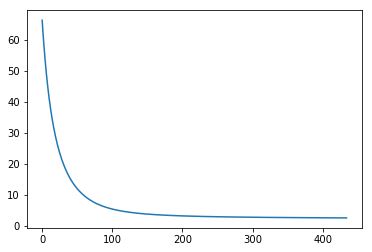

In [54]:
plt.plot(reg_res[1])
plt.show()

In [55]:
predicted_train_Y = []
train_X_ = np.append(train_X,np.ones([len(train_X[:,0]),1]),axis=1)
for i in range(len(train_X_[:,0])):
    predicted_train_Y.append(sum(reg_res[0]*train_X_[i,:]))

In [121]:
predicted_train_Y

[20.495356433501641,
 21.732832213886436,
 21.020224986145816,
 19.673736809594292,
 21.742166092039277,
 28.845055126575893,
 22.677502744002879,
 20.41200420200181,
 19.792880992150646,
 21.809877829634317,
 21.595241352992197,
 20.924201881539737,
 20.628840147635135,
 27.335680806699614,
 19.242784264322331,
 21.303461635657833,
 20.726357574891367,
 19.668267188533044,
 20.466561030411178,
 20.657596621887674,
 20.50855835779273,
 18.775358775890666,
 21.418102612816604,
 21.568049391291659,
 19.690334376636038,
 21.226837081333194,
 19.703317914465032,
 21.812790990218321,
 21.493931469151981,
 23.072058106210726,
 22.237406439988924,
 19.791863189873286,
 20.281015602800846,
 22.187478134565382,
 21.773458508846026,
 20.551738933199921,
 21.100832716586556,
 21.459231363482608,
 20.479191453333669,
 21.353897276206368,
 21.361161844980714,
 20.835671353636624,
 21.721188758730797,
 14.63192316139277,
 20.477852045032343,
 20.979050257550266,
 20.722601046648581,
 21.549850071720

In [122]:
train_Y

array([320, 370,  60, ...,  50,  50,  30])

In [110]:
#just for checking purpose
train_standard_X = train_X - train_X.mean(axis=0)
for i in range(len(train_standard_X[0,:])):
    train_standard_X[:,i] = train_standard_X[:,i]/np.max(train_standard_X[:,i])
train_standard_Y = (train_Y - train_Y.mean())/np.max(train_Y)

In [123]:
predicted_standard_Y = []
for i in range(len(train_standard_X[:,0])):
    predicted_standard_Y.append(sum(reg_res[0]*train_standard_X[1,:]))


In [115]:
train_standard_Y

array([ 0.24454889,  0.29949394, -0.0411654 , ..., -0.05215441,
       -0.05215441, -0.07413243])

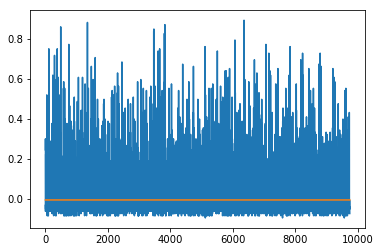

In [124]:
plt.plot(train_standard_Y)
plt.plot(predicted_standard_Y)
plt.show()